In [1]:
import phyflow as pf
import phyflow.monte_carlo as mc
import phyflow.phy_flow_matching as pfm
from pathlib import Path
import math
import numpy as np
import torch
from pytorch_lightning import seed_everything
from torch._inductor import config
from torchvision.transforms.v2 import Compose, RandomHorizontalFlip, RandomVerticalFlip
from torch.utils.data import ConcatDataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
import time
import logging

In [2]:
trash = []
seed_everything(3407, workers=True)
torch.set_float32_matmul_precision('high')
config.trace.log_autotuning_results = False
torch._logging.set_logs(inductor=logging.WARNING)
sympy_interp_logger = logging.getLogger("torch.utils._sympy.interp")
sympy_interp_logger.setLevel(logging.ERROR)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()
pf.get_complete_device_info()

2025-12-30 02:33:41,283 - INFO - Seed set to 3407


      Complete Device and Firmware Information
Operating System: Linux 6.6.87.2-microsoft-standard-WSL2
Architecture: x86_64
CPU Model: x86_64
CPU Full Model: AMD Ryzen 9 9950X 16-Core Processor
PyTorch Version: 2.7.1+cu128
CUDA Status: Available
CUDA Version (used by PyTorch): 12.8
Number of GPUs Available: 1
--- GPU 0 ---
  GPU Model: NVIDIA GeForce RTX 4080
  Total Memory: 17.17 GB
  Allocated Memory: 0.00 GB
  Cached Memory (Reserved): 0.00 GB
cuDNN Version: 90701


# System Size Extrapolation Lab

### Prepare the Monte Carlo data of the XY model

#### Validation Data

In [3]:
save_dir_root = './'
xy_generator = mc.MCDataGenerator(sampler_class=mc.XYModel, save_dir_root=save_dir_root)

L_val_list = [16, 32, 64, 128]
T_start_val_list = [0.1, 0.1, 0.1, 0.80]
T_end_val_list = [2.0, 2.0, 2.0, 1.05]
precision_val_list = [0.01, 0.01, 0.01, 0.005]
ensemble_number_val_list = [1500, 1500, 1500, 1000]

2025-12-30 02:33:41,383 - INFO - MCDataGenerator initialized for XYModel with save root: .


In [4]:
measurement_save_path_pt_list = []
config_save_path_pt_list = []

for L_index, L_val in enumerate(L_val_list):
    save_dir_root = Path(save_dir_root)
    sampler_name = mc.XYModel.__name__
    mc_data_dir = save_dir_root / "mc_data"
    sampler_dir = mc_data_dir / sampler_name
    field_config_dir = sampler_dir / "field_config"
    filename_base = f"{sampler_name}_L{L_val}_T{T_start_val_list[L_index]:.3f}-{T_end_val_list[L_index]:.3f}_prec{precision_val_list[L_index]:.3f}_ens{ensemble_number_val_list[L_index]}"
    filename_base = filename_base.replace('.', '_')
    config_save_path = field_config_dir / f"{filename_base}_configs.pt"
    measurement_dir = sampler_dir / "measurement"
    measurement_save_path_pt = measurement_dir / f"{filename_base}_measurements.pt"

    config_save_path_pt_list.append(config_save_path)
    measurement_save_path_pt_list.append(measurement_save_path_pt)


#### Training Data

In [5]:
save_dir_root = './'
xy_generator = mc.MCDataGenerator(sampler_class=mc.XYModel, save_dir_root=save_dir_root)

L = 32
T_start = 0.1
T_end = 2.0
precision = 0.01
ensemble_number = 1500
total_train_samples = (int((T_end-T_start)//precision)+1) * ensemble_number

2025-12-30 02:33:41,487 - INFO - MCDataGenerator initialized for XYModel with save root: .


In [6]:
xy_generator.forward(
    L=L,
    T_start=T_start,
    T_end=T_end,
    precision=precision,
    ensemble_number=ensemble_number,
    device=device,
)
trash.append(xy_generator)

2025-12-30 02:33:41,705 - INFO - --- Simulation Parameters for XYModel ---
2025-12-30 02:33:41,706 - INFO - Lattice size (L): 32
2025-12-30 02:33:41,706 - INFO - Temperature range: 0.1 to 2.0 (precision: 0.01, steps: 190)
2025-12-30 02:33:41,707 - INFO - Device: cuda:0
2025-12-30 02:33:41,707 - INFO - Ensemble number per T: 1500
2025-12-30 02:33:41,708 - INFO - Number of chains (n_chains): 10
2025-12-30 02:33:41,708 - INFO - Parallel Tempering: Enabled (interval: 1, prob: 0.1)
2025-12-30 02:33:41,709 - INFO - Calculated tau: 2048.0, tau_eff: 10.0
2025-12-30 02:33:41,710 - INFO - Thermalization sweeps (n_therm): 61440 (factor: 30)
2025-12-30 02:33:41,710 - INFO - Decorrelation sweeps (decorrelate): 19 (factor: 2)
2025-12-30 02:33:41,710 - INFO - Production sweeps (n_sweeps): 2850
2025-12-30 02:33:41,711 - INFO - -----------------------------------------------------
2025-12-30 02:33:41,869 - INFO - Starting Monte Carlo simulation...


Initialized MonteCarloSampler on device: cuda:0
 L=32, BatchSize=190, ChainsPerTemp=10, AMP=True, PT=True, LargeSim=False
Starting simulation: 61440 thermalization sweeps, 2850 production sweeps.
Thermalization phase...
Production phase...


2025-12-30 02:35:52,486 - INFO - Simulation finished. Elapsed time: 130.62 s
2025-12-30 02:35:52,487 - INFO - Generated samples shape: torch.Size([190, 1500, 32, 32])
2025-12-30 02:35:52,488 - INFO - Ensured directory exists: mc_data
2025-12-30 02:35:52,491 - INFO - Ensured directory exists: mc_data/XYModel
2025-12-30 02:35:52,494 - INFO - Ensured directory exists: mc_data/XYModel/field_config
2025-12-30 02:35:52,497 - INFO - Ensured directory exists: mc_data/XYModel/measurement


Simulation finished. Collected 1500 samples.


2025-12-30 02:35:52,510 - INFO - Saving field configurations to: mc_data/XYModel/field_config/XYModel_L32_T0_100-2_000_prec0_010_ens1500_configs.pt
2025-12-30 02:35:52,510 - INFO - Configs tensor shape: torch.Size([190, 1500, 32, 32])
2025-12-30 02:35:52,511 - INFO - Labels tensor shape: torch.Size([190, 2])


labels shape: torch.Size([190, 2])
first label pair: tensor([ 0.1000, 32.0000])


2025-12-30 02:35:58,327 - INFO - Field configurations saved.
2025-12-30 02:35:58,327 - INFO - Performing measurements...
2025-12-30 02:36:00,375 - INFO - Measurements complete.
2025-12-30 02:36:00,375 - INFO - Saving measurements dictionary to: mc_data/XYModel/measurement/XYModel_L32_T0_100-2_000_prec0_010_ens1500_measurements.pt
2025-12-30 02:36:00,389 - INFO - Measurements dictionary saved.
2025-12-30 02:36:00,389 - INFO - Saving plots to: mc_data/XYModel/measurement/XYModel_L32_T0_100-2_000_prec0_010_ens1500_plots.png
2025-12-30 02:36:00,969 - INFO - Plots saved.
2025-12-30 02:36:01,161 - INFO - Cleared CUDA cache.
2025-12-30 02:36:01,162 - INFO - MCDataGenerator call finished. Total time: 139.61 s


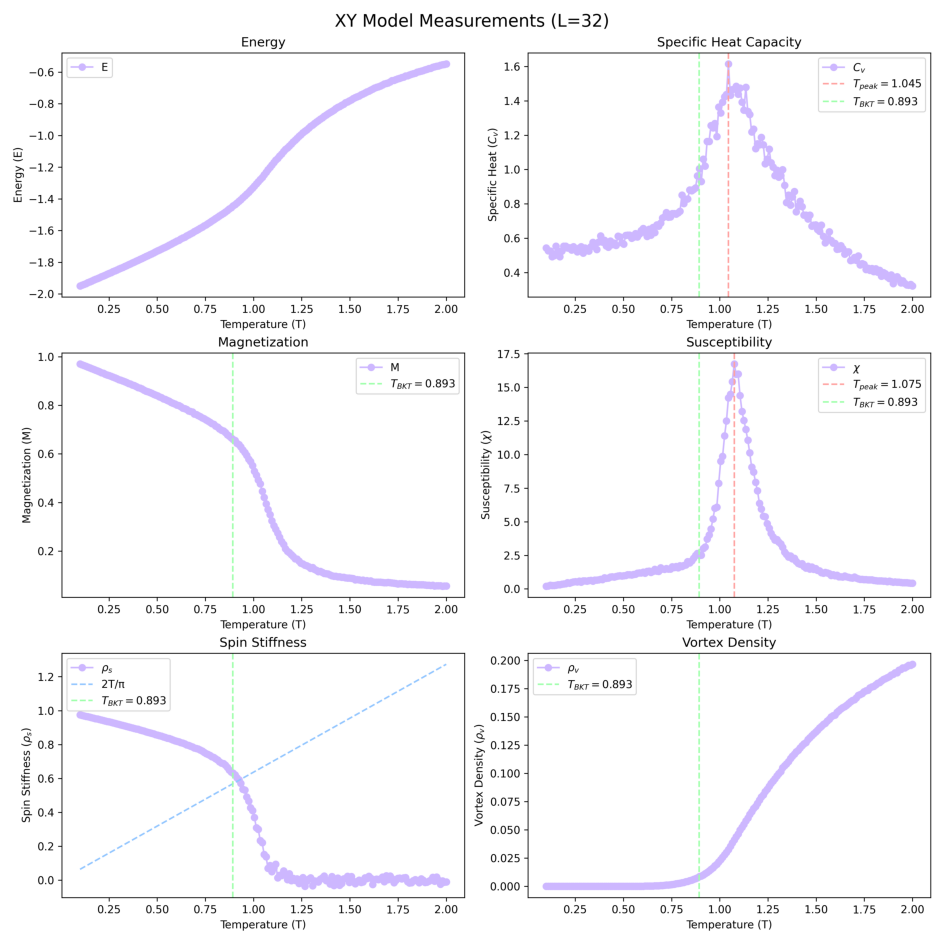

In [7]:
save_dir_root = Path(save_dir_root)
sampler_name = mc.XYModel.__name__
mc_data_dir = save_dir_root / "mc_data"
sampler_dir = mc_data_dir / sampler_name
field_config_dir = sampler_dir / "field_config"
filename_base = f"{sampler_name}_L{L}_T{T_start:.3f}-{T_end:.3f}_prec{precision:.3f}_ens{ensemble_number}"
filename_base = filename_base.replace('.', '_')
config_save_path = field_config_dir / f"{filename_base}_configs.pt"

mc_config_results = torch.load(config_save_path, map_location='cpu', weights_only=False)

measurement_dir = sampler_dir / "measurement"
measurement_save_path_pt = measurement_dir / f"{filename_base}_measurements.pt"

mc_measure_results = torch.load(measurement_save_path_pt, map_location='cpu', weights_only=False)

measurement_save_path_png = measurement_dir / f"{filename_base}_plots.png"
img = pf.load_image_pil(measurement_save_path_png)

pf.display_image_pil(img, figsize=(12, 12))

In [8]:
xy_spin_config = mc_config_results['configs']
labels = mc_config_results['labels']
T = torch.linspace(T_start, T_end, int((T_end - T_start) // precision) + 1, device=device)

xy_spin_config.shape

torch.Size([190, 1500, 32, 32])

In [9]:
trash.append(mc_config_results)
pf.clear_cuda_cache(trash)
trash = []

### Prepare the neural network

In [10]:
num_conditions = 1

model_parameter_dict = {
    'in_channels': 1,
    'out_channels': 1,
    'model_channels': 32,
    'downsample_out_ch_mult': (1, 1, 2,),
    'start_attn_level': 2,
    'num_blocks': 1,
    'dropout': 0.2,
    'num_heads': 4,
    'num_conditions': num_conditions,
    'emb_dim': 32,
    'padding_mode': 'circular',
}

model = pfm.FlowUNet(**model_parameter_dict).to(device)

dummy_inputs = {
    'x': torch.randn(32, 1, 32, 32, device="cuda"),
    'time': torch.randn(32, device="cuda"),
    'conditions': [torch.randn(32, device="cuda") for _ in range(num_conditions)]
}

pf.profile_model(model, dummy_inputs)

Parameters:                           214.65 K
FLOPs (floating point operations):    0.9776 G
Estimated memory usage (params only): 0.82 MB


#### Model Architecture

In [11]:
pf.check_model(model)

FlowUNet(
  (time_embedder): SinusoidalPosEmb()
  (time_mlp_embedders): MLPEmbedder(
    (mlp_emb_in_layer): Linear(in_features=32, out_features=128, bias=True)
    (mlp_emb_act): SiLU()
    (mlp_emb_out_layer): Linear(in_features=128, out_features=32, bias=True)
  )
  (cond_pos_embedders): ModuleList(
    (0): SinusoidalPosEmb()
  )
  (cond_mlp_embedders): ModuleList(
    (0): MLPEmbedder(
      (mlp_emb_in_layer): Linear(in_features=32, out_features=128, bias=True)
      (mlp_emb_act): SiLU()
      (mlp_emb_out_layer): Linear(in_features=128, out_features=32, bias=True)
    )
  )
  (mlp_msa): ConditionalMSAWithRoPE(
    (norm): RMSNorm((32,), eps=1e-06, elementwise_affine=True)
    (seq_expand_proj): Linear(in_features=2, out_features=32, bias=True)
    (qkv_projection): Linear(in_features=32, out_features=96, bias=False)
    (rope): RoPE()
    (seq_combine_proj): Linear(in_features=32, out_features=1, bias=False)
  )
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padd

### Prepare the dataset

In [12]:
t_focus_start_1 = 0.0
t_focus_end_1 = 1.38
t_focus_start_index_1 = len(T[T <= t_focus_start_1])
t_focus_end_index_1 = len(T[T <= t_focus_end_1])

In [13]:
labels_selected = labels[:, 0]

transform_1 = Compose([
    pfm.RandomGlobalRotation(),
    pfm.RandomRoll(max_shift=(L//2, L//2), p=1.0),
    RandomHorizontalFlip(p=0.5),
    pfm.RandomRoll(max_shift=(L//2, L//2), p=1.0),
    pfm.RandomGlobalRotation(),
    RandomVerticalFlip(p=0.5),
    pfm.RandomRoll(max_shift=(L//2, L//2), p=1.0),
    pfm.RandomGlobalRotation(),
    pfm.RandomRoll(max_shift=(L//2, L//2), p=1.0),
])

xy_dataset_raw = mc.MCDataset(
    data=xy_spin_config,
    labels=labels_selected,
)

xy_dataset_transform_1 = mc.MCDataset(
    data=xy_spin_config,
    labels=labels_selected,
    transform=transform_1,
)

xy_spin_config_focus = xy_spin_config[t_focus_start_index_1:t_focus_end_index_1, ...]
labels_selected_focus = labels_selected[t_focus_start_index_1:t_focus_end_index_1, ...]

reps = math.ceil(xy_spin_config.shape[0] / xy_spin_config_focus.shape[0])
repeated_config_focus = xy_spin_config_focus.repeat(reps,1,1,1)[:xy_spin_config.shape[0], ...]
repeated_labels_focus = labels_selected_focus.repeat(reps)[:xy_spin_config.shape[0], ...]

xy_dataset_focus_1_transform_1 = mc.MCDataset(
    data=repeated_config_focus,
    labels=repeated_labels_focus,
    transform=transform_1,
)

xy_dataset = ConcatDataset([
    xy_dataset_raw,
    xy_dataset_transform_1,
    xy_dataset_focus_1_transform_1
])

batch_size = 32
batch_size_mod = pf.find_closest_factor(len(xy_dataset), batch_size)
print(f"Optimal batch size: {batch_size_mod}")

xy_dataloader = DataLoader(xy_dataset, batch_size=batch_size_mod,shuffle=True)

trash.append(xy_spin_config_focus)
pf.clear_cuda_cache(trash)
trash = []

Optimal batch size: 30


In [14]:
def random_global_rotate(x: torch.Tensor) -> torch.Tensor:
    """Apply a random global rotation (phase shift) to each 2-D field in a batch.

    The same random scalar θ ∈ [0, 2π) is added to **all** spatial positions
    in each sample.  After the shift, the result is wrapped into the range
    `[0, 2π)` with a modulo operation.

    Args:
        x (torch.Tensor): Input tensor of shape **(B, 1, H, W)** and any
            floating‐point dtype.

    Returns:
        torch.Tensor: Tensor with the same shape, dtype, and device as `x`,
        where for every *b* in `0 … B-1`

        ```text
        y[b, 0, :, :] = (x[b, 0, :, :] + θ_b) mod 2π.
        ```

    Notes:
        * The function is fully differentiable.
        * If `x` requires gradients, the returned tensor will as well.

    """
    if x.ndim != 4 or x.size(1) != 1:
        raise ValueError(
            f"Expected input of shape (B, 1, H, W); got {tuple(x.shape)}"
        )

    # Draw B independent scalars θ_b ∈ [0, 2π) with the same dtype/device as `x`.
    theta: torch.Tensor = torch.rand(
        x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device
    ) * (2 * torch.pi)

    # Add and wrap into [0, 2π).
    y: torch.Tensor = torch.fmod(x + theta, 2 * torch.pi)

    return (y - torch.pi) / torch.pi  # Shift to [-1, 1] range for better training stability.
    # return y

### Prepare the save path

In [15]:
save_root = './'
save_folder_name = 'system_size_extrapolation_log'
pf.create_directory(root_path=save_root, folder_name=save_folder_name)
fm_save_dir_root = Path(save_root) / save_folder_name

### Prepare the flow matching executor

In [16]:
gradient_accumulation_steps = 4
base_lr = gradient_accumulation_steps * 2e-4
total_epochs = 10

# init optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=0.1)

scheduler = OneCycleLR(
    optimizer=optimizer,
    max_lr=base_lr,
    total_steps=total_epochs+1,
    pct_start=1/3
)

fmex = pfm.CFMExecutor(
    save_dir_root=fm_save_dir_root,
    model_params=model_parameter_dict,
    model=model,
    model_wrapper=pfm.CFMWrapper,
    optimizer=optimizer,
    lr_scheduler=scheduler,
    device=device,
)

2025-12-30 02:36:29,814 - INFO - Save directory root 'system_size_extrapolation_log' confirmed/created.
2025-12-30 02:36:29,816 - INFO - AutoClip initialized with percentile=10.0, window_size=1000.
2025-12-30 02:36:29,816 - INFO - CFMExecutor initialized. Device: cuda:0
2025-12-30 02:36:29,817 - INFO - Save directory root: system_size_extrapolation_log
2025-12-30 02:36:29,817 - WARNING - Base distribution p0 not provided. Likelihood computation will default to standard Normal or may not be available if data shape is incompatible.


### Train the model

In [17]:
torch.cuda.empty_cache()
torch.cuda.synchronize(device)

train_start = time.time()
# fmex.load_checkpoint('./pretrained_models/trained_on_xy_L32_with_temp_precision_0_05.pth')
fmex.train(
    train_loaders=(
        xy_dataloader,
    ),
    num_epochs=total_epochs,
    save_every_epochs=10,
    gradient_accumulation_steps=gradient_accumulation_steps,
    mu_logit=0.0,
    sigma_logit = 1.0,
    data_argumentation_fn=random_global_rotate
)
train_end = time.time()

train_time = train_end - train_start
print(f"Training took {train_time:.2f} seconds.")

2025-12-30 02:36:29,907 - INFO - Total batches per epoch from all loaders: 28500
2025-12-30 02:36:29,907 - INFO - Effective batch size (approx, based on first loader): 120
2025-12-30 02:36:29,908 - INFO - Starting training for 10 epochs.
2025-12-30 02:36:29,908 - INFO - Gradient Accumulation Steps: 4
2025-12-30 02:36:29,908 - INFO - Using logit-normal sampler with mu_logit=0.0000, sigma_logit=1.0000. This controls the sampling distribution for time t.
2025-12-30 02:42:50,737 - INFO - Epoch 1/10 completed in 380.83s.                                              
2025-12-30 02:42:50,737 - INFO -   Average Epoch Loss: 1.1330
2025-12-30 02:42:50,739 - INFO -   Optimizer steps in epoch: 7125
2025-12-30 02:42:50,739 - INFO -   Last AutoClip threshold used: 1.1166
2025-12-30 02:42:50,739 - INFO -   LR scheduler stepped. New LR: 0.000269
2025-12-30 02:42:50,740 - INFO - ------------------------------------------------------------
2025-12-30 02:42:50,740 - INFO - Keeping sigma_logit = 1.0000 fo

Training took 3587.15 seconds.


### Sample with the trained model and compare with Monte Carlo

#### Sample at the training size

In [18]:
fmex.load_checkpoint(fm_save_dir_root/f'checkpoints/checkpoint_epoch_{total_epochs:04d}.pth')

2025-12-30 03:36:17,212 - INFO - Loaded AutoClip gradient history from checkpoint.
2025-12-30 03:36:17,213 - INFO - Loaded checkpoint from system_size_extrapolation_log/checkpoints/checkpoint_epoch_0010.pth. Last completed epoch: 10.
2025-12-30 03:36:17,213 - INFO - Training will resume from epoch 11.
2025-12-30 03:36:17,214 - INFO -   Last recorded average epoch loss: 0.5452
2025-12-30 03:36:17,214 - INFO -   Associated model params from checkpoint: {'in_channels': 1, 'out_channels': 1, 'model_channels': 32, 'downsample_out_ch_mult': (1, 1, 2), 'start_attn_level': 2, 'num_blocks': 1, 'dropout': 0.2, 'num_heads': 4, 'num_conditions': 1, 'emb_dim': 32, 'padding_mode': 'circular'}


In [19]:
L = 32
Temp_start = T_start_val_list[L_val_list.index(L)]
Temp_end = T_end_val_list[L_val_list.index(L)]
precision = precision_val_list[L_val_list.index(L)]
num_samples = ensemble_number_val_list[L_val_list.index(L)]
num_steps = 5
timestep_schedule_mu = -0.3
timestep_schedule_sigma = 1.0

num_temp = int((Temp_end-Temp_start)//precision)+1
print(f'num_temp: {num_temp}')

B_opt = pf.estimate_max_batch_size(
    model = model,
    num_data=num_temp * num_samples,
    channels=1,
    height=L,
    width=L,
    time_steps=num_steps,
    num_conditions=num_conditions,
    num_evals=3,
    device=device,
    use_adjoint=False,
    safety_factor=0.9
)
print(f"Optimal batch size: {B_opt}")
B_opt_mod = pf.find_closest_factor(num_temp * num_samples, B_opt)
print(f"Optimal batch size (modify): {B_opt_mod}")

Temp = torch.linspace(Temp_start, Temp_end, steps=num_temp)
x_init = torch.randn((num_temp, num_samples, L, L), dtype=torch.float32)

xy_inference_dataset = mc.MCDataset(data=x_init, labels=Temp)
xy_inference_dataloader = DataLoader(xy_inference_dataset, batch_size=B_opt_mod, shuffle=False)

num_temp: 190
Optimal batch size: 622
Optimal batch size (modify): 625


In [20]:
torch.cuda.empty_cache()
torch.cuda.synchronize(device)

_ = fmex.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=10,
    for_gpu_warmup=True,
    do_log=False,
)

sol_size_32_start_time = time.time()
sol_size_32 = fmex.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=num_steps,
    method='heun3',
    timestep_schedule_mu=timestep_schedule_mu,
    timestep_schedule_sigma=timestep_schedule_sigma,
)
sol_size_32_end_time = time.time()
torch.cuda.empty_cache()

sol_size_32_time = sol_size_32_end_time - sol_size_32_start_time

sol_size_32_time_per_sample = sol_size_32_time / (num_temp * num_samples)

train_sol_size_32_time_per_sample = (sol_size_32_time / (num_temp * num_samples)) + train_time / total_train_samples

print(f"Solving time per sample for L=32: {sol_size_32_time_per_sample:.5f} seconds")

2025-12-30 03:36:29,219 - INFO - Performing GPU warmup. No actual sampling will be done.
Solving ODE (Sampling):   0%|          | 0/456 [00:00<?, ?it/s]AUTOTUNE addmm(640000x128, 640000x32, 32x128)
  triton_mm_17 0.6574 ms 100.0% ACC_TYPE='tl.float32', ALLOW_TF32=True, BLOCK_K=16, BLOCK_M=32, BLOCK_N=32, EVEN_K=True, GROUP_M=8, num_stages=1, num_warps=2
  triton_mm_21 0.6594 ms 99.7% ACC_TYPE='tl.float32', ALLOW_TF32=True, BLOCK_K=32, BLOCK_M=64, BLOCK_N=32, EVEN_K=True, GROUP_M=8, num_stages=5, num_warps=4
  triton_mm_22 0.6595 ms 99.7% ACC_TYPE='tl.float32', ALLOW_TF32=True, BLOCK_K=16, BLOCK_M=64, BLOCK_N=64, EVEN_K=True, GROUP_M=8, num_stages=2, num_warps=4
  triton_mm_20 0.6605 ms 99.5% ACC_TYPE='tl.float32', ALLOW_TF32=True, BLOCK_K=32, BLOCK_M=64, BLOCK_N=32, EVEN_K=True, GROUP_M=8, num_stages=5, num_warps=8
  triton_mm_26 0.6605 ms 99.5% ACC_TYPE='tl.float32', ALLOW_TF32=True, BLOCK_K=32, BLOCK_M=64, BLOCK_N=128, EVEN_K=True, GROUP_M=8, num_stages=3, num_warps=4
  triton_mm_28 

Solving time per sample for L=32: 0.00051 seconds


In [21]:
sampler_xy = mc.XYModel(
    L=L,
    T=Temp,
    device=torch.device(device),
    use_amp=True
)

sampler_xy.spins = sol_size_32 * torch.pi + torch.pi  # Shift to [0, 2π) range.
trash.append(sol_size_32)

Initialized MonteCarloSampler on device: cuda:0
 L=32, BatchSize=190, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False


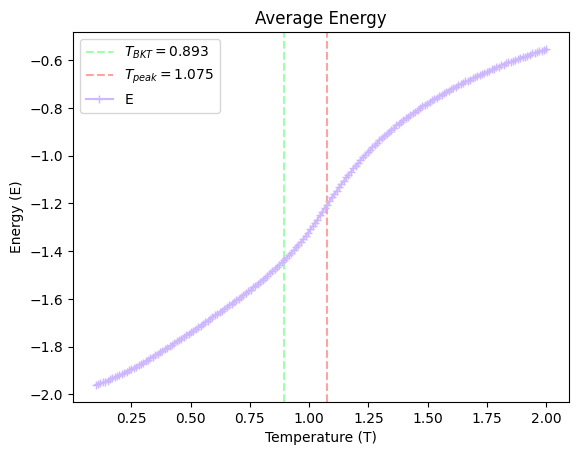

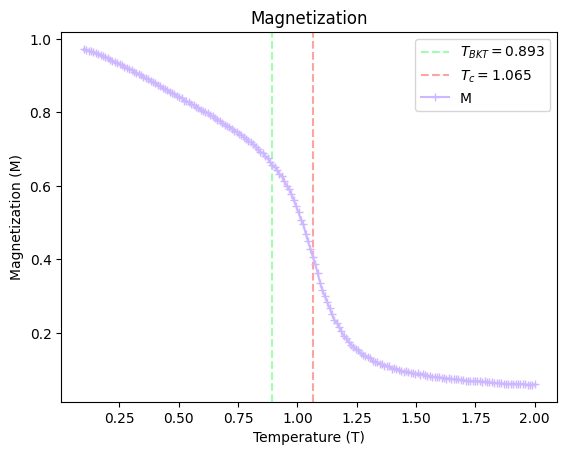

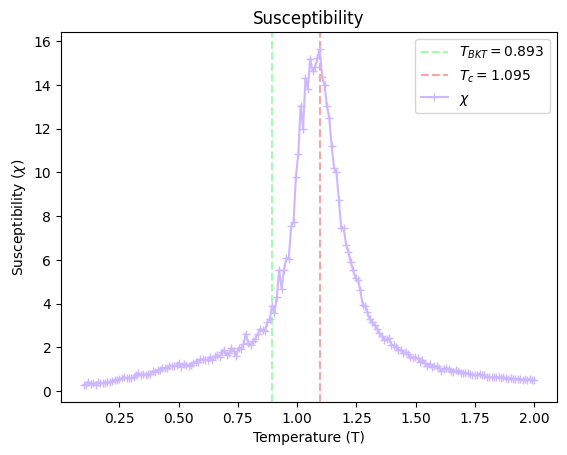

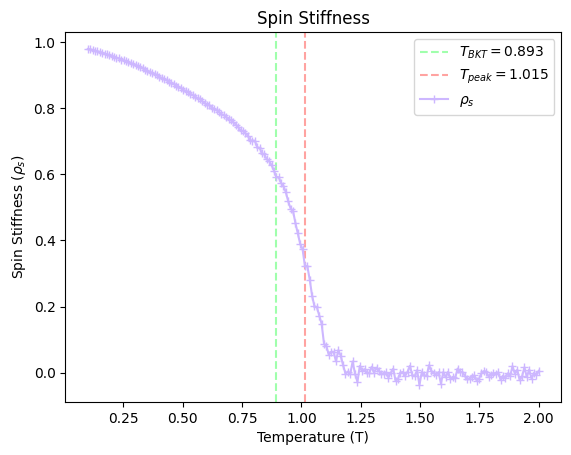

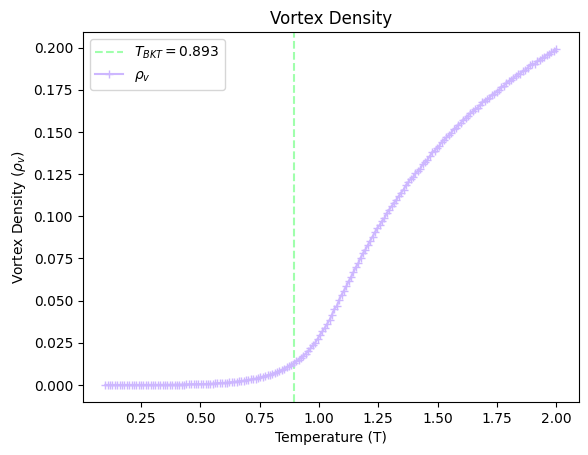

In [22]:
fm_energy_size_32 = sampler_xy.plot_energy(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_magnetization_size_32 = sampler_xy.plot_magnetization(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_susceptibility_size_32 = sampler_xy.plot_susceptibility(
    plot_t_bkt=True,
    plot_peak_line=True,
    return_observation=True
)
fm_stiffness_size_32 = sampler_xy.plot_stiffness(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_vortex_density_size_32 = sampler_xy.plot_vortex_density(
    plot_t_bkt=True,
    low_memory=True,
    return_observation=True
)

In [23]:
mc_size_32_measure_results = torch.load(
    measurement_save_path_pt_list[L_val_list.index(32)],
    map_location='cpu', weights_only=False
)
mc_size_32_temperature = mc_size_32_measure_results['temperature']
mc_size_32_energy = mc_size_32_measure_results['energy']
mc_size_32_magnetization = mc_size_32_measure_results['magnetization']
mc_size_32_susceptibility = mc_size_32_measure_results['susceptibility']
mc_size_32_stiffness = mc_size_32_measure_results['spin_stiffness']
mc_size_32_vortex_density = mc_size_32_measure_results['vortex_density']

In [24]:
mc_size_32_config_results = torch.load(
    config_save_path_pt_list[L_val_list.index(32)],
    map_location='cpu', weights_only=False
)
mc_size_32_time_per_sample \
    = mc_size_32_config_results['spend_time'] / (mc_size_32_config_results['params']['ensemble_number'] * len(mc_size_32_temperature))
trash.append(mc_size_32_config_results)
pf.clear_cuda_cache(trash)
trash = []

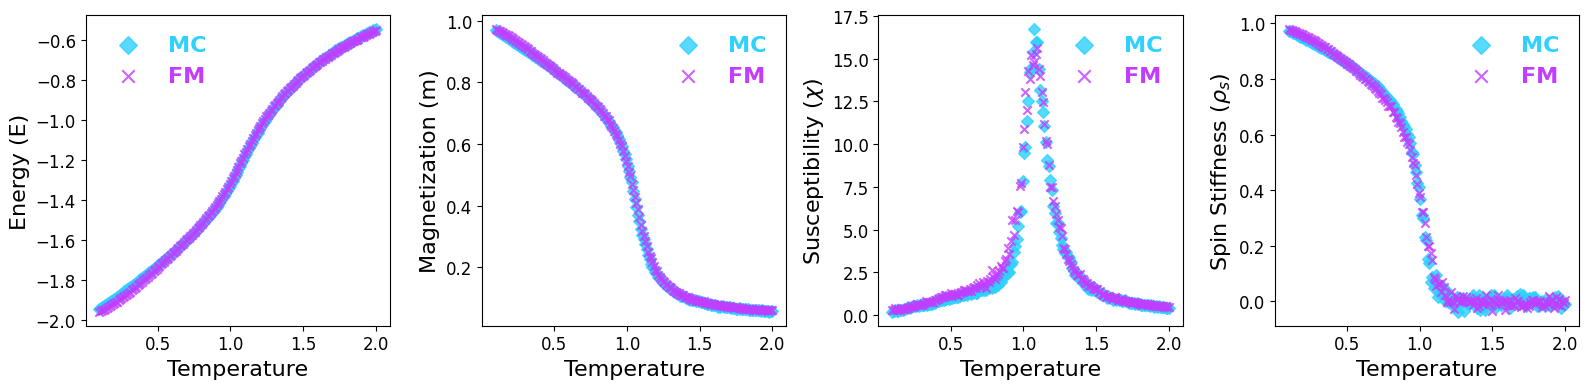

In [25]:
plt.style.use('seaborn-v0_8-pastel')

mc_color = "#2ED1FF"
fm_color = '#C23DFF'

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].scatter(mc_size_32_temperature, mc_size_32_energy, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[0].scatter(Temp.cpu(), fm_energy_size_32, marker='x', label='FM', color=fm_color, alpha=0.8)
ax[0].set_ylabel('Energy (E)', fontsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=12)
# ax[0].set_title('Energy', fontsize=16)

ax[1].scatter(mc_size_32_temperature, mc_size_32_magnetization, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[1].scatter(Temp.cpu(), fm_magnetization_size_32, marker='x', label='FM', color=fm_color, alpha=0.8)
ax[1].set_ylabel('Magnetization (m)', fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=12)
# ax[1].set_title('Magnetization', fontsize=16)

ax[2].scatter(mc_size_32_temperature, mc_size_32_susceptibility, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[2].scatter(Temp.cpu(), fm_susceptibility_size_32, marker='x', label='FM', color=fm_color, alpha=0.8)
ax[2].set_ylabel(r'Susceptibility ($\chi$)', fontsize=16)
ax[2].tick_params(axis='both', which='major', labelsize=12)
# ax[2].set_title('Susceptibility', fontsize=16)

ax[3].scatter(mc_size_32_temperature, mc_size_32_stiffness, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[3].scatter(Temp.cpu(), fm_stiffness_size_32, marker='x', label='FM', color=fm_color, alpha=0.8)
ax[3].set_ylabel(r'Spin Stiffness ($\rho_s$)', fontsize=16)
ax[3].tick_params(axis='both', which='major', labelsize=12)
# ax[3].set_title('Spin Stiffness', fontsize=16)

for i in range(4):
    ax[i].set_xlabel('Temperature', fontsize=16)
    ax[i].legend(
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_color, fm_color],
        markerscale=1.5,
        frameon=False
    )
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

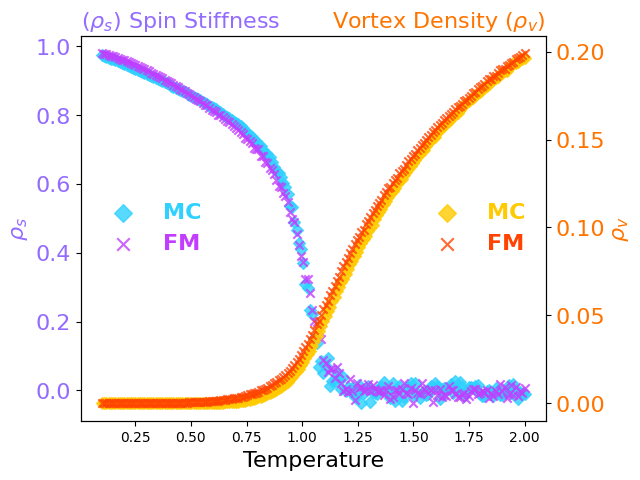

In [26]:
plt.clf()
plt.style.use('seaborn-v0_8-pastel')

mc_stiffness_color = "#2ED1FF"
fm_stiffness_color = '#C23DFF'

mc_vortex_density_color = "#FFCB00"
fm_vortex_density_color = "#FF4300"

stiffness_axis_color= "#936BFF"
vortex_axis_color = '#FF7400'


fig, ax1 = plt.subplots(figsize=(6, 5))
ax1.scatter(mc_size_32_temperature, mc_size_32_stiffness, marker='D', label='MC', color=mc_stiffness_color, alpha=0.8)
ax1.scatter(Temp.cpu(), fm_stiffness_size_32, marker='x', label='FM', color=fm_stiffness_color, alpha=0.8)
ax1.set_xlabel('Temperature', fontsize=16)
ax1.set_ylabel(r'$\rho_s$', fontsize=16, color=stiffness_axis_color)
ax1.set_title(r'($\rho_s$) Spin Stiffness', fontsize=16, color=stiffness_axis_color, loc='left')
ax1.tick_params(axis='y', labelsize=16, labelcolor=stiffness_axis_color)

ax1.legend(
        loc='center left',
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_stiffness_color, fm_stiffness_color],
        markerscale=1.5,
        frameon=False
    )

ax2 = ax1.twinx()
ax2.scatter(mc_size_32_temperature, mc_size_32_vortex_density, marker='D', label='MC', color=mc_vortex_density_color, alpha=0.8)
ax2.scatter(Temp.cpu(), fm_vortex_density_size_32, marker='x', label='FM', color=fm_vortex_density_color, alpha=0.8)
ax2.set_ylabel(r'$\rho_v$', fontsize=16, color=vortex_axis_color)
ax2.set_title(r'Vortex Density ($\rho_v$)', fontsize=16, color=vortex_axis_color, loc='right')
ax2.tick_params(axis='y', labelsize=16, labelcolor=vortex_axis_color)

ax2.legend(
        loc='center right',
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_vortex_density_color, fm_vortex_density_color],
        markerscale=1.5,
        frameon=False
    )

plt.show()

In [27]:
trash.append(sampler_xy)
trash.append(xy_spin_config)
pf.clear_cuda_cache(trash)
trash = []

### Sample beyond the training size

#### Sample at the smaller size

In [28]:
L = 16
Temp_start = T_start_val_list[L_val_list.index(L)]
Temp_end = T_end_val_list[L_val_list.index(L)]
precision = precision_val_list[L_val_list.index(L)]
num_samples = ensemble_number_val_list[L_val_list.index(L)]
num_steps = 5
timestep_schedule_mu = -0.3
timestep_schedule_sigma = 1.0

num_temp = int((Temp_end-Temp_start)//precision)+1
print(f'num_temp: {num_temp}')

B_opt = pf.estimate_max_batch_size(
    model = model,
    num_data=num_temp * num_samples,
    channels=1,
    height=L,
    width=L,
    time_steps=num_steps,
    num_conditions=num_conditions,
    num_evals=3,
    device=device,
    use_adjoint=False,
    safety_factor=0.9
)
print(f"Optimal batch size: {B_opt}")
B_opt_mod = pf.find_closest_factor(num_temp * num_samples, B_opt)
print(f"Optimal batch size (modify): {B_opt_mod}")

Temp = torch.linspace(Temp_start, Temp_end, steps=num_temp)
x_init = torch.randn((num_temp, num_samples, L, L), dtype=torch.float32)

xy_inference_dataset = mc.MCDataset(data=x_init, labels=Temp)
xy_inference_dataloader = DataLoader(xy_inference_dataset, batch_size=B_opt_mod, shuffle=False)

num_temp: 190
Optimal batch size: 2497
Optimal batch size (modify): 2500


In [29]:
torch.cuda.empty_cache()
torch.cuda.synchronize(device)

_ = fmex.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=10,
    for_gpu_warmup=True,
    do_log=False,
)

sol_size_16_start_time = time.time()
sol_size_16 = fmex.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=num_steps,
    method='heun3',
    timestep_schedule_mu=timestep_schedule_mu,
    timestep_schedule_sigma=timestep_schedule_sigma,
)
sol_size_16_end_time = time.time()
torch.cuda.empty_cache()

sol_size_16_time = sol_size_16_end_time - sol_size_16_start_time

sol_size_16_time_per_sample = sol_size_16_time / (num_temp * num_samples)

train_sol_size_16_time_per_sample = (sol_size_16_time / (num_temp * num_samples)) + train_time / total_train_samples

print(f"Solving time per sample for L=16: {sol_size_16_time_per_sample:.5f} seconds")

2025-12-30 03:39:47,294 - INFO - Performing GPU warmup. No actual sampling will be done.
Solving ODE (Sampling):   0%|          | 0/114 [00:00<?, ?it/s]AUTOTUNE convolution(2500x32x16x16, 128x32x1x1)
  triton_convolution2d_159 0.6615 ms 100.0% ALLOW_TF32=True, BLOCK_K=32, BLOCK_M=64, BLOCK_N=128, GROUPS=1, KERNEL_H=1, KERNEL_W=1, PADDING_H=0, PADDING_W=0, STRIDE_H=1, STRIDE_W=1, UNROLL=True, num_stages=2, num_warps=8
  convolution 0.6636 ms 99.7% 
  triton_convolution2d_157 0.6646 ms 99.5% ALLOW_TF32=True, BLOCK_K=32, BLOCK_M=128, BLOCK_N=128, GROUPS=1, KERNEL_H=1, KERNEL_W=1, PADDING_H=0, PADDING_W=0, STRIDE_H=1, STRIDE_W=1, UNROLL=True, num_stages=2, num_warps=8
  triton_convolution2d_154 0.6656 ms 99.4% ALLOW_TF32=True, BLOCK_K=16, BLOCK_M=64, BLOCK_N=128, GROUPS=1, KERNEL_H=1, KERNEL_W=1, PADDING_H=0, PADDING_W=0, STRIDE_H=1, STRIDE_W=1, UNROLL=True, num_stages=2, num_warps=4
  triton_convolution2d_158 0.8100 ms 81.7% ALLOW_TF32=True, BLOCK_K=32, BLOCK_M=64, BLOCK_N=64, GROUPS=1, K

Solving time per sample for L=16: 0.00014 seconds


In [30]:
sampler_xy = mc.XYModel(
    L=L,
    T=Temp,
    device=torch.device(device),
    use_amp=True
)

sampler_xy.spins = sol_size_16 * torch.pi + torch.pi  # Shift to [0, 2π) range.
trash.append(sol_size_16)

Initialized MonteCarloSampler on device: cuda:0
 L=16, BatchSize=190, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False


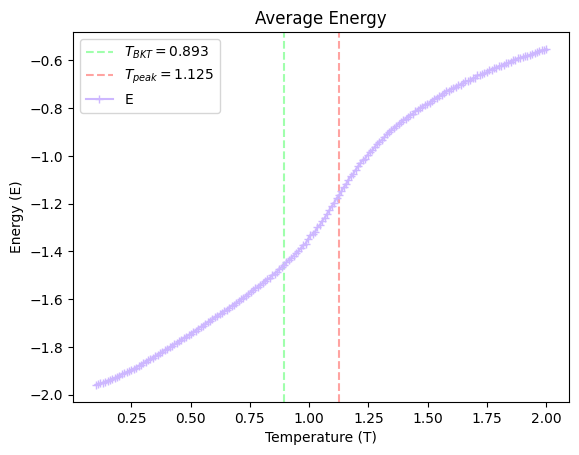

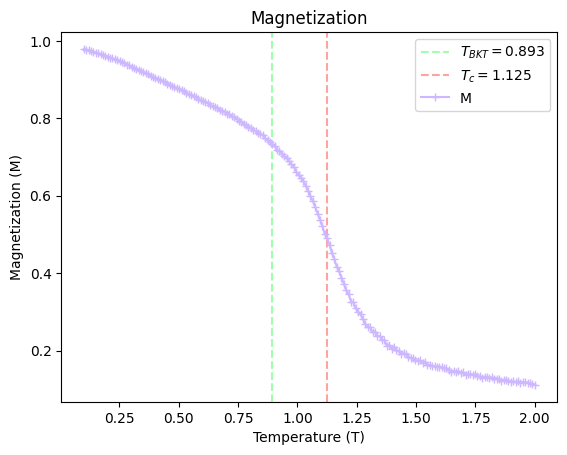

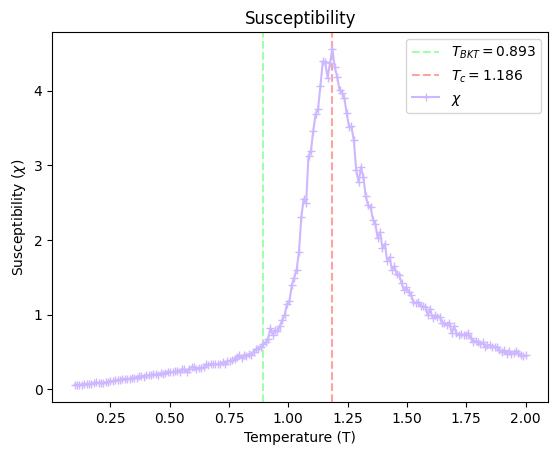

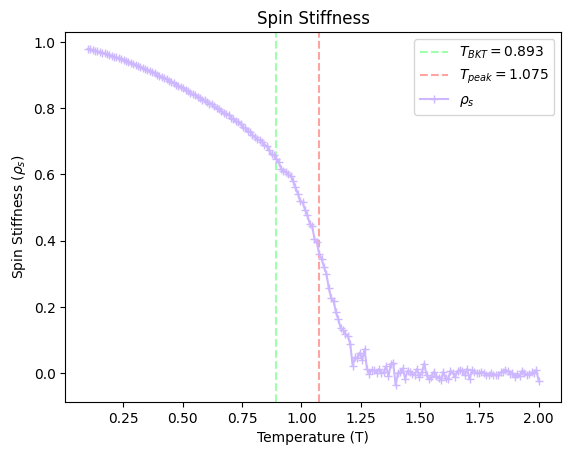

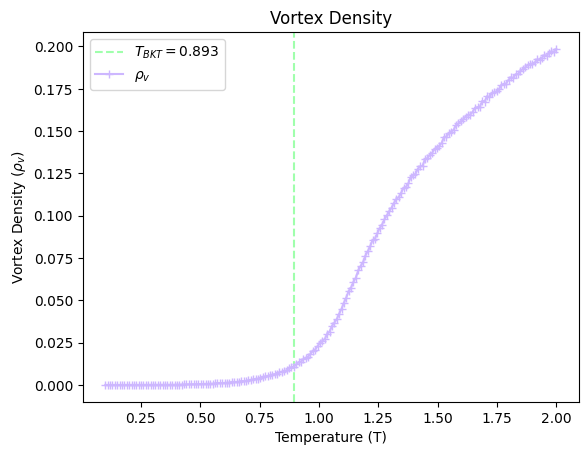

In [31]:
fm_energy_size_16 = sampler_xy.plot_energy(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_magnetization_size_16 = sampler_xy.plot_magnetization(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_susceptibility_size_16 = sampler_xy.plot_susceptibility(
    plot_t_bkt=True,
    plot_peak_line=True,
    return_observation=True
)
fm_stiffness_size_16 = sampler_xy.plot_stiffness(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_vortex_density_size_16 = sampler_xy.plot_vortex_density(
    plot_t_bkt=True,
    low_memory=True,
    return_observation=True
)

In [32]:
mc_size_16_measure_results = torch.load(
    measurement_save_path_pt_list[L_val_list.index(16)],
    map_location='cpu', weights_only=False
)
mc_size_16_temperature = mc_size_16_measure_results['temperature']
mc_size_16_energy = mc_size_16_measure_results['energy']
mc_size_16_magnetization = mc_size_16_measure_results['magnetization']
mc_size_16_susceptibility = mc_size_16_measure_results['susceptibility']
mc_size_16_stiffness = mc_size_16_measure_results['spin_stiffness']
mc_size_16_vortex_density = mc_size_16_measure_results['vortex_density']

In [33]:
mc_size_16_config_results = torch.load(
    config_save_path_pt_list[L_val_list.index(16)],
    map_location='cpu', weights_only=False
)
mc_size_16_time_per_sample \
    = mc_size_16_config_results['spend_time'] / (mc_size_16_config_results['params']['ensemble_number'] * len(mc_size_16_temperature))
trash.append(mc_size_16_config_results)
pf.clear_cuda_cache(trash)
trash = []

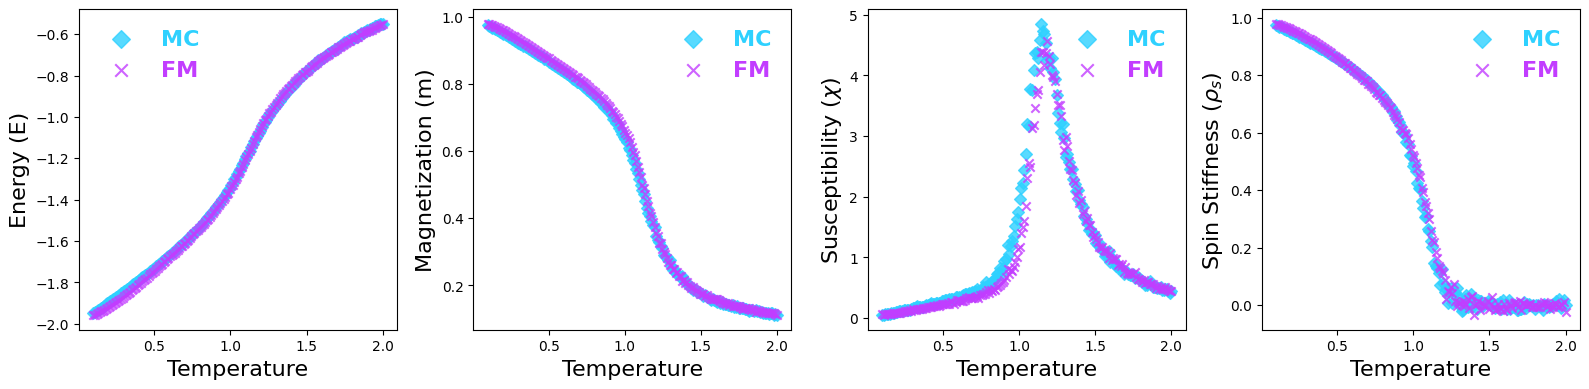

In [34]:
plt.style.use('seaborn-v0_8-pastel')

mc_color = "#2ED1FF"
fm_color = '#C23DFF'

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].scatter(mc_size_16_temperature, mc_size_16_energy, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[0].scatter(Temp.cpu(), fm_energy_size_16, marker='x', label='FM', color=fm_color, alpha=0.8)
ax[0].set_ylabel('Energy (E)', fontsize=16)
# ax[0].set_title('Energy', fontsize=16)

ax[1].scatter(mc_size_16_temperature, mc_size_16_magnetization, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[1].scatter(Temp.cpu(), fm_magnetization_size_16, marker='x', label='FM', color=fm_color, alpha=0.8)
ax[1].set_ylabel('Magnetization (m)', fontsize=16)
# ax[1].set_title('Magnetization', fontsize=16)

ax[2].scatter(mc_size_16_temperature, mc_size_16_susceptibility, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[2].scatter(Temp.cpu(), fm_susceptibility_size_16, marker='x', label='FM', color=fm_color, alpha=0.8)
ax[2].set_ylabel(r'Susceptibility ($\chi$)', fontsize=16)
# ax[2].set_title('Susceptibility', fontsize=16)

ax[3].scatter(mc_size_16_temperature, mc_size_16_stiffness, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[3].scatter(Temp.cpu(), fm_stiffness_size_16, marker='x', label='FM', color=fm_color, alpha=0.8)
ax[3].set_ylabel(r'Spin Stiffness ($\rho_s$)', fontsize=16)
# ax[3].set_title('Spin Stiffness', fontsize=16)

for i in range(4):
    ax[i].set_xlabel('Temperature', fontsize=16)
    ax[i].legend(
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_color, fm_color],
        markerscale=1.5,
        frameon=False
    )
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

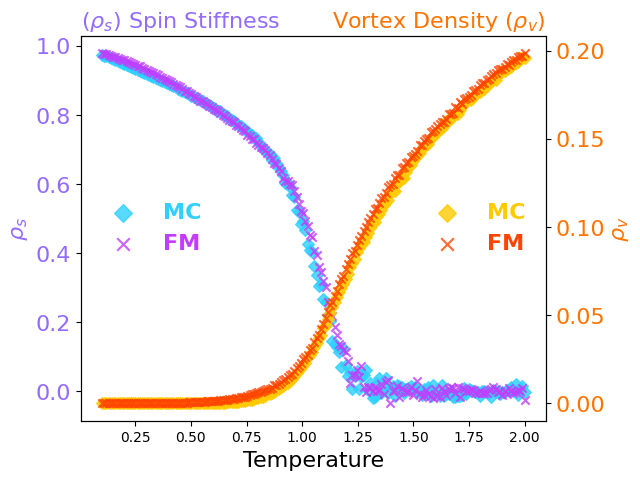

In [35]:
plt.clf()
plt.style.use('seaborn-v0_8-pastel')

mc_stiffness_color = "#2ED1FF"
fm_stiffness_color = '#C23DFF'

mc_vortex_density_color = "#FFCB00"
fm_vortex_density_color = "#FF4300"

stiffness_axis_color= "#936BFF"
vortex_axis_color = '#FF7400'


fig, ax1 = plt.subplots(figsize=(6, 5))
ax1.scatter(mc_size_16_temperature, mc_size_16_stiffness, marker='D', label='MC', color=mc_stiffness_color, alpha=0.8)
ax1.scatter(Temp.cpu(), fm_stiffness_size_16, marker='x', label='FM', color=fm_stiffness_color, alpha=0.8)
ax1.set_xlabel('Temperature', fontsize=16)
ax1.set_ylabel(r'$\rho_s$', fontsize=16, color=stiffness_axis_color)
ax1.set_title(r'($\rho_s$) Spin Stiffness', fontsize=16, color=stiffness_axis_color, loc='left')
ax1.tick_params(axis='y', labelsize=16, labelcolor=stiffness_axis_color)

ax1.legend(
        loc='center left',
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_stiffness_color, fm_stiffness_color],
        markerscale=1.5,
        frameon=False
    )

ax2 = ax1.twinx()
ax2.scatter(mc_size_16_temperature, mc_size_16_vortex_density, marker='D', label='MC', color=mc_vortex_density_color, alpha=0.8)
ax2.scatter(Temp.cpu(), fm_vortex_density_size_16, marker='x', label='FM', color=fm_vortex_density_color, alpha=0.8)
ax2.set_ylabel(r'$\rho_v$', fontsize=16, color=vortex_axis_color)
ax2.set_title(r'Vortex Density ($\rho_v$)', fontsize=16, color=vortex_axis_color, loc='right')
ax2.tick_params(axis='y', labelsize=16, labelcolor=vortex_axis_color)

ax2.legend(
        loc='center right',
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_vortex_density_color, fm_vortex_density_color],
        markerscale=1.5,
        frameon=False
    )

plt.show()

In [36]:
trash.append(sampler_xy)
pf.clear_cuda_cache(trash)
trash = []

#### Sample at the larger size

#### L=64

In [37]:
L = 64
Temp_start = T_start_val_list[L_val_list.index(L)]
Temp_end = T_end_val_list[L_val_list.index(L)]
precision = precision_val_list[L_val_list.index(L)]
num_samples = ensemble_number_val_list[L_val_list.index(L)]
num_steps = 5
timestep_schedule_mu = -0.3
timestep_schedule_sigma = 1.0

num_temp = int((Temp_end-Temp_start)//precision)+1
print(f'num_temp: {num_temp}')

B_opt = pf.estimate_max_batch_size(
    model = model,
    num_data=num_temp * num_samples,
    channels=1,
    height=L,
    width=L,
    time_steps=num_steps,
    num_conditions=num_conditions,
    num_evals=3,
    device=device,
    use_adjoint=False,
    safety_factor=0.9
)
print(f"Optimal batch size: {B_opt}")
B_opt_mod = pf.find_closest_factor(num_temp * num_samples, B_opt)
print(f"Optimal batch size (modify): {B_opt_mod}")

Temp = torch.linspace(Temp_start, Temp_end, steps=num_temp)
x_init = torch.randn((num_temp, num_samples, L, L), dtype=torch.float32)

xy_inference_dataset = mc.MCDataset(data=x_init, labels=Temp)
xy_inference_dataloader = DataLoader(xy_inference_dataset, batch_size=B_opt_mod, shuffle=False)

num_temp: 190
Optimal batch size: 159
Optimal batch size (modify): 152


In [38]:
torch.cuda.empty_cache()
torch.cuda.synchronize(device)

_ = fmex.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=10,
    for_gpu_warmup=True,
    do_log=False,
)

sol_size_64_start_time = time.time()
sol_size_64 = fmex.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=num_steps,
    method='heun3',
    timestep_schedule_mu=timestep_schedule_mu,
    timestep_schedule_sigma=timestep_schedule_sigma,
)
sol_size_64_end_time = time.time()
torch.cuda.empty_cache()

sol_size_64_time = sol_size_64_end_time - sol_size_64_start_time

sol_size_64_time_per_sample = sol_size_64_time / (num_temp * num_samples)

train_sol_size_64_time_per_sample = (sol_size_64_time / (num_temp * num_samples)) + train_time / total_train_samples

print(f"Solving time per sample for L=64: {sol_size_64_time_per_sample:.5f} seconds")

2025-12-30 03:41:10,742 - INFO - Performing GPU warmup. No actual sampling will be done.
Solving ODE (Sampling):   0%|          | 0/1875 [00:00<?, ?it/s]AUTOTUNE convolution(152x64x16x16, 256x64x1x1)
  triton_convolution2d_261 0.0707 ms 100.0% ALLOW_TF32=True, BLOCK_K=32, BLOCK_M=128, BLOCK_N=128, GROUPS=1, KERNEL_H=1, KERNEL_W=1, PADDING_H=0, PADDING_W=0, STRIDE_H=1, STRIDE_W=1, UNROLL=True, num_stages=2, num_warps=8
  triton_convolution2d_258 0.0850 ms 83.2% ALLOW_TF32=True, BLOCK_K=16, BLOCK_M=64, BLOCK_N=256, GROUPS=1, KERNEL_H=1, KERNEL_W=1, PADDING_H=0, PADDING_W=0, STRIDE_H=1, STRIDE_W=1, UNROLL=True, num_stages=2, num_warps=4
  triton_convolution2d_259 0.0850 ms 83.1% ALLOW_TF32=True, BLOCK_K=16, BLOCK_M=256, BLOCK_N=64, GROUPS=1, KERNEL_H=1, KERNEL_W=1, PADDING_H=0, PADDING_W=0, STRIDE_H=1, STRIDE_W=1, UNROLL=True, num_stages=2, num_warps=4
  triton_convolution2d_263 0.0850 ms 83.1% ALLOW_TF32=True, BLOCK_K=32, BLOCK_M=64, BLOCK_N=256, GROUPS=1, KERNEL_H=1, KERNEL_W=1, PADDING

Solving time per sample for L=64: 0.00219 seconds


In [39]:
sampler_xy = mc.XYModel(
    L=L,
    T=Temp,
    device=torch.device(device),
    use_amp=True
)

# sampler_xy.spins = sol_size_64 * torch.pi + torch.pi  # Shift to [0, 2π) range.
# trash.append(sol_size_64)

samples_size_64 = sol_size_64 * torch.pi + torch.pi  # Shift to [0, 2π) range for sampling.
trash.append(sol_size_64)

analyzer_size_64 = mc.JackknifeAnalysis(sampler_xy, samples_size_64.to(device))

final_results_size_64 = analyzer_size_64.compute_all_errors(bin_size=50)

trash.append(samples_size_64)

analyzer_size_64.print_report(final_results_size_64)

Initialized MonteCarloSampler on device: cuda:0
 L=64, BatchSize=190, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Pre-computing raw observables from samples...
Raw observables computed.
Temp     | Energy             | Cv                 | Mag                | Chi                | Stiffness          | Vortex            
--------------------------------------------------------------------------------------------------------------------------------------------
0.100    | -1.9645±0.0001     | 5.8398±0.9829      | 0.9690±0.0001      | 0.6266±0.0319      | 0.9821±0.0001      | 0.0000±0.0000     
0.110    | -1.9611±0.0001     | 4.4212±0.8762      | 0.9664±0.0001      | 0.7794±0.0569      | 0.9803±0.0001      | 0.0000±0.0000     
0.120    | -1.9574±0.0001     | 3.8633±0.7467      | 0.9640±0.0001      | 0.7914±0.0463      | 0.9785±0.0001      | 0.0000±0.0000     
0.130    | -1.9535±0.0001     | 3.7046±0.6508      | 0.9612±0.0001      | 0.7545±0.0490      | 0.9766±0.0001      | 0.0000±0.

In [40]:
fm_energy_size_64 = final_results_size_64['Energy']['mean'].cpu().numpy()
fm_energy_size_64_err = final_results_size_64['Energy']['error'].cpu().numpy()

fm_magnetization_size_64 = final_results_size_64['Magnetization']['mean'].cpu().numpy()
fm_magnetization_size_64_err = final_results_size_64['Magnetization']['error'].cpu().numpy()

fm_susceptibility_size_64 = final_results_size_64['Susceptibility']['mean'].cpu().numpy()
fm_susceptibility_size_64_err = final_results_size_64['Susceptibility']['error'].cpu().numpy()

fm_stiffness_size_64 = final_results_size_64['Stiffness']['mean'].cpu().numpy()
fm_stiffness_size_64_err = final_results_size_64['Stiffness']['error'].cpu().numpy()

fm_vortex_density_size_64 = final_results_size_64['Vortex_Density']['mean'].cpu().numpy()
fm_vortex_density_size_64_err = final_results_size_64['Vortex_Density']['error'].cpu().numpy()

In [41]:
# fm_energy_size_64 = sampler_xy.plot_energy(
#     plot_t_bkt=True,
#     plot_first_derivative_peak=True,
#     return_observation=True
# )
# fm_magnetization_size_64 = sampler_xy.plot_magnetization(
#     plot_t_bkt=True,
#     plot_first_derivative_peak=True,
#     return_observation=True
# )
# fm_susceptibility_size_64 = sampler_xy.plot_susceptibility(
#     plot_t_bkt=True,
#     plot_peak_line=True,
#     return_observation=True
# )
# fm_stiffness_size_64 = sampler_xy.plot_stiffness(
#     plot_t_bkt=True,
#     plot_first_derivative_peak=True,
#     return_observation=True
# )
# fm_vortex_density_size_64 = sampler_xy.plot_vortex_density(
#     plot_t_bkt=True,
#     low_memory=True,
#     return_observation=True
# )

In [42]:
mc_size_64_measure_results = torch.load(
    measurement_save_path_pt_list[L_val_list.index(64)],
    map_location='cpu', weights_only=False
)
mc_size_64_temperature = mc_size_64_measure_results['temperature']
mc_size_64_energy = mc_size_64_measure_results['energy']
mc_size_64_magnetization = mc_size_64_measure_results['magnetization']
mc_size_64_susceptibility = mc_size_64_measure_results['susceptibility']
mc_size_64_stiffness = mc_size_64_measure_results['spin_stiffness']
mc_size_64_vortex_density = mc_size_64_measure_results['vortex_density']

In [43]:
mc_size_64_config_results = torch.load(
    config_save_path_pt_list[L_val_list.index(64)],
    map_location='cpu', weights_only=False
)

mc_size_64_time_per_sample \
    = mc_size_64_config_results['spend_time'] / (mc_size_64_config_results['params']['ensemble_number'] * len(mc_size_64_temperature))
trash.append(mc_size_64_config_results)
pf.clear_cuda_cache(trash)
trash = []

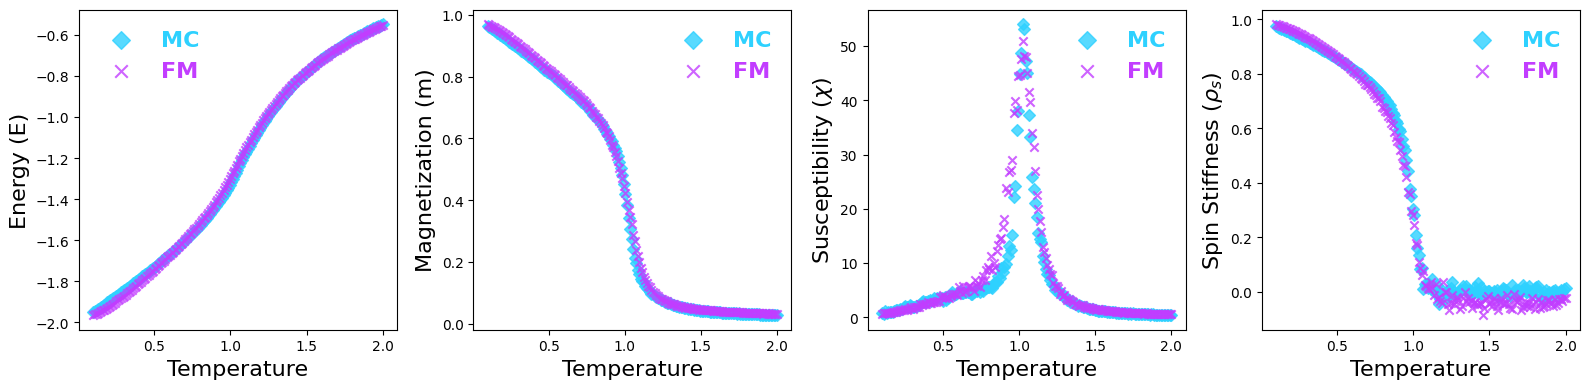

In [44]:
plt.style.use('seaborn-v0_8-pastel')

mc_color = "#2ED1FF"
fm_color = '#C23DFF'

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].scatter(mc_size_64_temperature, mc_size_64_energy, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[0].scatter(Temp.cpu(), fm_energy_size_64, marker='x', label='FM', color=fm_color, alpha=0.8)
ax[0].set_ylabel('Energy (E)', fontsize=16)
# ax[0].set_title('Energy', fontsize=16)

ax[1].scatter(mc_size_64_temperature, mc_size_64_magnetization, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[1].scatter(Temp.cpu(), fm_magnetization_size_64, marker='x', label='FM', color=fm_color, alpha=0.8)
ax[1].set_ylabel('Magnetization (m)', fontsize=16)
# ax[1].set_title('Magnetization', fontsize=16)

ax[2].scatter(mc_size_64_temperature, mc_size_64_susceptibility, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[2].scatter(Temp.cpu(), fm_susceptibility_size_64, marker='x', label='FM', color=fm_color, alpha=0.8)
ax[2].set_ylabel(r'Susceptibility ($\chi$)', fontsize=16)
# ax[2].set_title('Susceptibility', fontsize=16)

ax[3].scatter(mc_size_64_temperature, mc_size_64_stiffness, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[3].scatter(Temp.cpu(), fm_stiffness_size_64, marker='x', label='FM', color=fm_color, alpha=0.8)
ax[3].set_ylabel(r'Spin Stiffness ($\rho_s$)', fontsize=16)
# ax[3].set_title('Spin Stiffness', fontsize=16)

for i in range(4):
    ax[i].set_xlabel('Temperature', fontsize=16)
    ax[i].legend(
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_color, fm_color],
        markerscale=1.5,
        frameon=False
    )
plt.tight_layout()
plt.show()

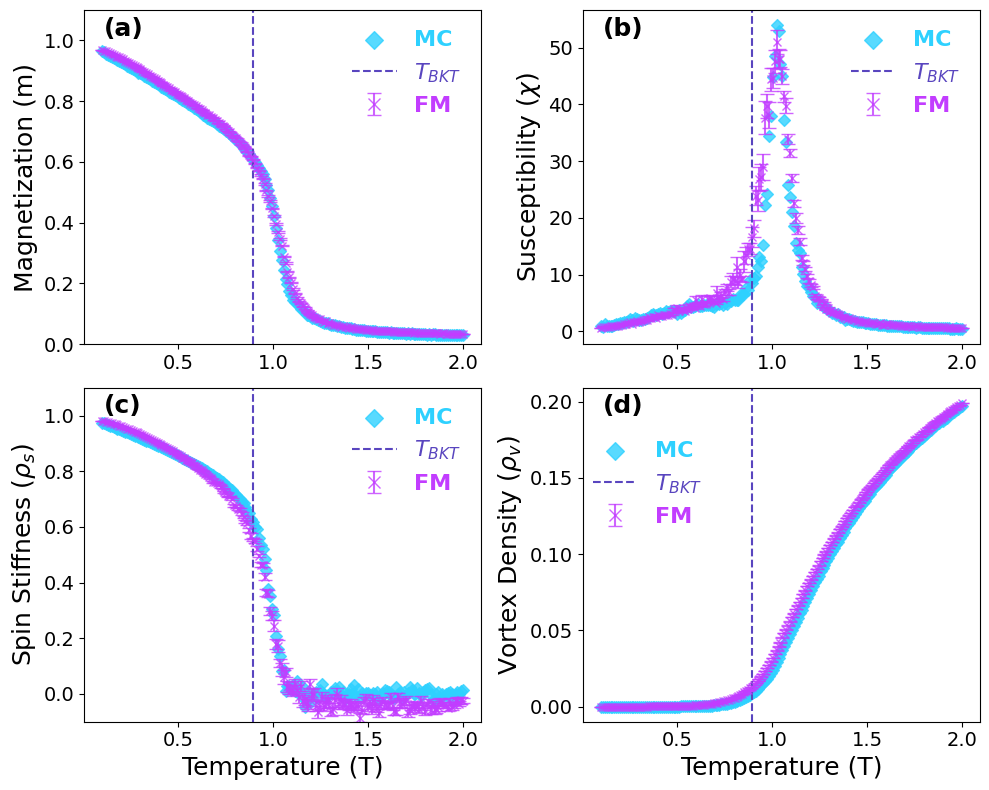

In [45]:
plt.style.use('seaborn-v0_8-pastel')

mc_color = "#2ED1FF"
fm_color = '#C23DFF'

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
# ax[0].scatter(mc_size_64_temperature, mc_size_64_energy, marker='D', label='MC', color=mc_color, alpha=0.8)
# ax[0].scatter(Temp.cpu(), fm_energy_size_64, marker='x', label='FM', color=fm_color, alpha=0.8)
# ax[0].set_ylabel('Energy (E)', fontsize=16)
# ax[0].set_title('Energy', fontsize=16)

tc_bkt = 0.8935

ax[0,0].scatter(mc_size_64_temperature, mc_size_64_magnetization, marker='D', label='MC', color=mc_color, alpha=0.8)
# ax[0,0].scatter(Temp.cpu(), fm_magnetization_size_64, marker='x', label='FM', color=fm_color, alpha=0.8)
ax[0,0].errorbar(Temp.cpu(), fm_magnetization_size_64, yerr=fm_magnetization_size_64_err, fmt='x', capsize=5, label='FM', color=fm_color, alpha=0.8)
ax[0,0].axvline(tc_bkt, linestyle='--', label=f'$T_{{BKT}}$', color='#5945BF')
ax[0,0].set_ylabel('Magnetization (m)', fontsize=18)
# ax[0,0].set_title('Magnetization', fontsize=16)
ax[0,0].tick_params(axis='both', which='major', labelsize=14)
ax[0,0].set_ylim(0, 1.1)
ax[0,0].text(0.05, 0.98, '(a)', transform=ax[0,0].transAxes,
         fontsize=18, fontweight='bold', va='top')

ax[0,1].scatter(mc_size_64_temperature, mc_size_64_susceptibility, marker='D', label='MC', color=mc_color, alpha=0.8)
# ax[0,1].scatter(Temp.cpu(), fm_susceptibility_size_64, marker='x', label='FM', color=fm_color, alpha=0.8)
ax[0,1].errorbar(Temp.cpu(), fm_susceptibility_size_64, yerr=fm_susceptibility_size_64_err, fmt='x', capsize=5, label='FM', color=fm_color, alpha=0.8)
ax[0,1].axvline(tc_bkt, linestyle='--', label=f'$T_{{BKT}}$', color='#5945BF')
ax[0,1].set_ylabel(r'Susceptibility ($\chi$)', fontsize=18)
# ax[0,1].set_title('Susceptibility', fontsize=16)
ax[0,1].tick_params(axis='both', which='major', labelsize=14)
ax[0,1].text(0.05, 0.98, '(b)', transform=ax[0,1].transAxes,
         fontsize=18, fontweight='bold', va='top')

ax[1,0].scatter(mc_size_64_temperature, mc_size_64_stiffness, marker='D', label='MC', color=mc_color, alpha=0.8)
# ax[1,0].scatter(Temp.cpu(), fm_stiffness_size_64, marker='x', label='FM', color=fm_color, alpha=0.8)
ax[1,0].errorbar(Temp.cpu(), fm_stiffness_size_64, yerr=fm_stiffness_size_64_err, fmt='x', capsize=5, label='FM', color=fm_color, alpha=0.8)
ax[1,0].axvline(tc_bkt, linestyle='--', label=f'$T_{{BKT}}$', color='#5945BF')
ax[1,0].set_ylabel(r'Spin Stiffness ($\rho_s$)', fontsize=18)
# ax[1,0].set_title('Spin Stiffness', fontsize=16)
ax[1,0].tick_params(axis='both', which='major', labelsize=14)
ax[1,0].set_ylim(-0.1, 1.1)
ax[1,0].text(0.05, 0.98, '(c)', transform=ax[1,0].transAxes,
         fontsize=18, fontweight='bold', va='top')

ax[1,1].scatter(mc_size_64_temperature, mc_size_64_vortex_density, marker='D', label='MC', color=mc_color, alpha=0.8)
# ax[1,1].scatter(Temp.cpu(), fm_vortex_density_size_64, marker='x', label='FM', color=fm_color, alpha=0.8)
ax[1,1].errorbar(Temp.cpu(), fm_vortex_density_size_64, yerr=fm_vortex_density_size_64_err, fmt='x', capsize=5, label='FM', color=fm_color, alpha=0.8)
ax[1,1].axvline(tc_bkt, linestyle='--', label=f'$T_{{BKT}}$', color='#5945BF')
ax[1,1].set_ylabel(r'Vortex Density ($\rho_v$)', fontsize=18)
# ax[1,1].set_title('Vortex Density', fontsize=16)
ax[1,1].tick_params(axis='both', which='major', labelsize=14)
ax[1,1].text(0.05, 0.98, '(d)', transform=ax[1,1].transAxes,
         fontsize=18, fontweight='bold', va='top')

for i in range(2):
    for j in range(2):
        if i == 1:
            ax[i, j].set_xlabel('Temperature (T)', fontsize=18)
        if i == 1 and j == 1:
            ax[i, j].legend(
                prop={'weight': 'bold', 'size': 16},
                labelcolor=[mc_color, '#5945BF', fm_color],
                markerscale=1.5,
                bbox_to_anchor=(0.35, 0.9),
                frameon=False
            )
        else:
            ax[i, j].legend(
                prop={'weight': 'bold', 'size': 16},
                labelcolor=[mc_color, '#5945BF', fm_color],
                markerscale=1.5,
                frameon=False
            )
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

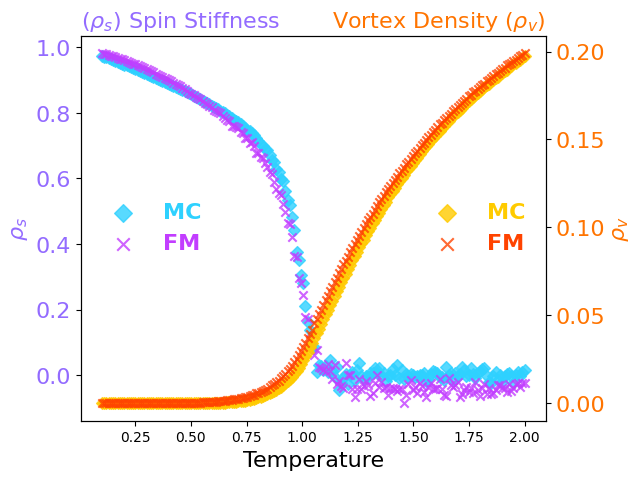

In [46]:
plt.clf()
plt.style.use('seaborn-v0_8-pastel')

mc_stiffness_color = "#2ED1FF"
fm_stiffness_color = '#C23DFF'

mc_vortex_density_color = "#FFCB00"
fm_vortex_density_color = "#FF4300"

stiffness_axis_color= "#936BFF"
vortex_axis_color = '#FF7400'


fig, ax1 = plt.subplots(figsize=(6, 5))
ax1.scatter(mc_size_64_temperature, mc_size_64_stiffness, marker='D', label='MC', color=mc_stiffness_color, alpha=0.8)
ax1.scatter(Temp.cpu(), fm_stiffness_size_64, marker='x', label='FM', color=fm_stiffness_color, alpha=0.8)
ax1.set_xlabel('Temperature', fontsize=16)
ax1.set_ylabel(r'$\rho_s$', fontsize=16, color=stiffness_axis_color)
ax1.set_title(r'($\rho_s$) Spin Stiffness', fontsize=16, color=stiffness_axis_color, loc='left')
ax1.tick_params(axis='y', labelsize=16, labelcolor=stiffness_axis_color)

ax1.legend(
        loc='center left',
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_stiffness_color, fm_stiffness_color],
        markerscale=1.5,
        frameon=False
    )

ax2 = ax1.twinx()
ax2.scatter(mc_size_64_temperature, mc_size_64_vortex_density, marker='D', label='MC', color=mc_vortex_density_color, alpha=0.8)
ax2.scatter(Temp.cpu(), fm_vortex_density_size_64, marker='x', label='FM', color=fm_vortex_density_color, alpha=0.8)
ax2.set_ylabel(r'$\rho_v$', fontsize=16, color=vortex_axis_color)
ax2.set_title(r'Vortex Density ($\rho_v$)', fontsize=16, color=vortex_axis_color, loc='right')
ax2.tick_params(axis='y', labelsize=16, labelcolor=vortex_axis_color)

ax2.legend(
        loc='center right',
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_vortex_density_color, fm_vortex_density_color],
        markerscale=1.5,
        frameon=False
    )

plt.show()

In [47]:
trash.append(sampler_xy)
pf.clear_cuda_cache(trash)
trash = []

#### L=128

In [48]:
L = 128
Temp_start = T_start_val_list[L_val_list.index(L)]
Temp_end = T_end_val_list[L_val_list.index(L)]
precision = precision_val_list[L_val_list.index(L)]
num_samples = ensemble_number_val_list[L_val_list.index(L)]
num_steps = 5
timestep_schedule_mu = -0.3
timestep_schedule_sigma = 1.0

num_temp = int((Temp_end-Temp_start)//precision)+1
print(f'num_temp: {num_temp}')

B_opt = pf.estimate_max_batch_size(
    model = model,
    num_data=num_temp * num_samples,
    channels=1,
    height=L,
    width=L,
    time_steps=num_steps,
    num_conditions=num_conditions,
    num_evals=3,
    device=device,
    use_adjoint=False,
    safety_factor=0.9
)
print(f"Optimal batch size: {B_opt}")
B_opt_mod = pf.find_closest_factor(num_temp * num_samples, B_opt)
print(f"Optimal batch size (modify): {B_opt_mod}")

Temp_128 = torch.linspace(Temp_start, Temp_end, steps=num_temp)
x_init = torch.randn((num_temp, num_samples, L, L), dtype=torch.float32)

xy_inference_dataset = mc.MCDataset(data=x_init, labels=Temp_128)
xy_inference_dataloader = DataLoader(xy_inference_dataset, batch_size=B_opt_mod, shuffle=False)

num_temp: 50
Optimal batch size: 28
Optimal batch size (modify): 25


In [49]:
torch.cuda.empty_cache()
torch.cuda.synchronize(device)

_ = fmex.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=10,
    for_gpu_warmup=True,
    do_log=False,
)

sol_size_128_start_time = time.time()
sol_size_128 = fmex.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=num_steps,
    method='heun3',
    timestep_schedule_mu=timestep_schedule_mu,
    timestep_schedule_sigma=timestep_schedule_sigma,
)
sol_size_128_end_time = time.time()
torch.cuda.empty_cache()

sol_size_128_time = sol_size_128_end_time - sol_size_128_start_time

sol_size_128_time_per_sample = sol_size_128_time / (num_temp * num_samples)

train_sol_size_128_time_per_sample = (sol_size_128_time / (num_temp * num_samples)) + train_time / total_train_samples

print(f"Solving time per sample for L=128: {sol_size_128_time_per_sample:.5f} seconds")

2025-12-30 03:52:47,265 - INFO - Performing GPU warmup. No actual sampling will be done.
Solving ODE (Sampling):   0%|          | 0/2000 [00:00<?, ?it/s]AUTOTUNE convolution(25x64x32x32, 256x64x1x1)
  triton_convolution2d_323 0.0553 ms 100.0% ALLOW_TF32=True, BLOCK_K=32, BLOCK_M=64, BLOCK_N=64, GROUPS=1, KERNEL_H=1, KERNEL_W=1, PADDING_H=0, PADDING_W=0, STRIDE_H=1, STRIDE_W=1, UNROLL=True, num_stages=2, num_warps=4
  triton_convolution2d_320 0.0554 ms 99.8% ALLOW_TF32=True, BLOCK_K=16, BLOCK_M=256, BLOCK_N=64, GROUPS=1, KERNEL_H=1, KERNEL_W=1, PADDING_H=0, PADDING_W=0, STRIDE_H=1, STRIDE_W=1, UNROLL=True, num_stages=2, num_warps=4
  triton_convolution2d_324 0.0584 ms 94.7% ALLOW_TF32=True, BLOCK_K=32, BLOCK_M=64, BLOCK_N=256, GROUPS=1, KERNEL_H=1, KERNEL_W=1, PADDING_H=0, PADDING_W=0, STRIDE_H=1, STRIDE_W=1, UNROLL=True, num_stages=2, num_warps=8
  triton_convolution2d_325 0.0594 ms 93.1% ALLOW_TF32=True, BLOCK_K=32, BLOCK_M=256, BLOCK_N=64, GROUPS=1, KERNEL_H=1, KERNEL_W=1, PADDING_H=

Solving time per sample for L=128: 0.01059 seconds


In [50]:
sampler_xy = mc.XYModel(
    L=L,
    T=Temp_128,
    device=torch.device(device),
    use_amp=True
)

sampler_xy.spins = sol_size_128 * torch.pi + torch.pi  # Shift to [0, 2π) range.
trash.append(sol_size_128)

Initialized MonteCarloSampler on device: cuda:0
 L=128, BatchSize=50, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False


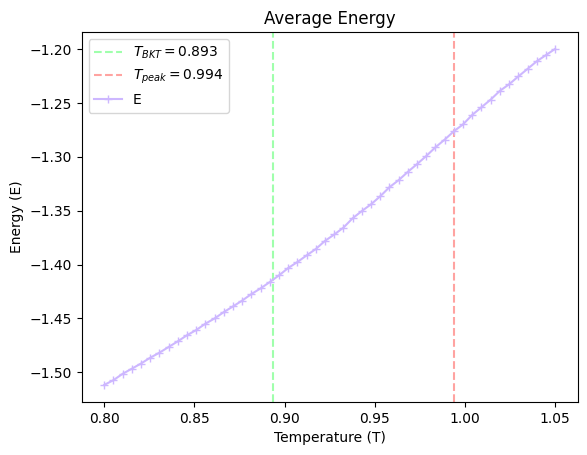

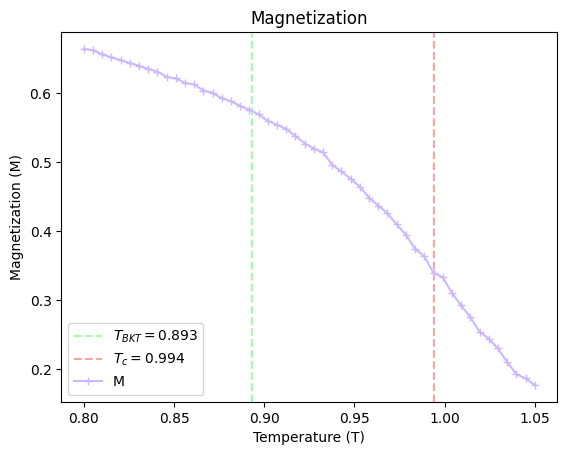

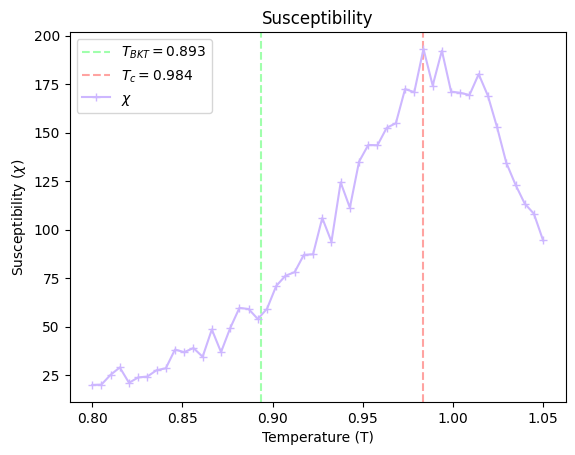

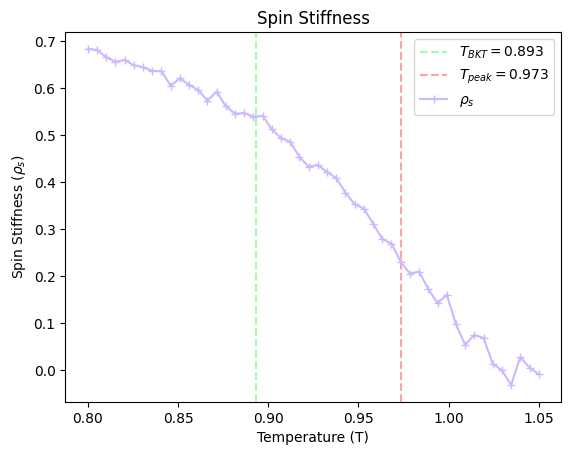

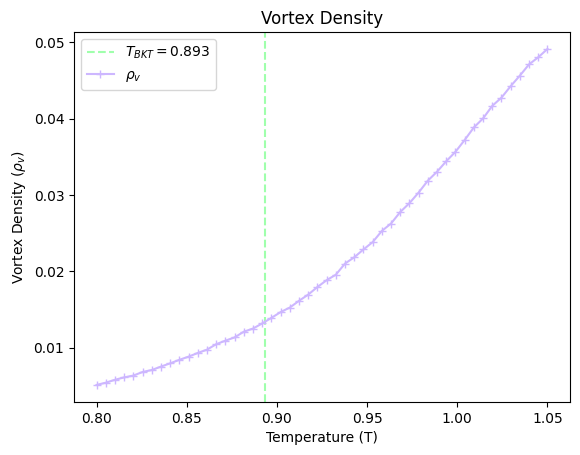

In [51]:
fm_energy_size_128 = sampler_xy.plot_energy(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_magnetization_size_128 = sampler_xy.plot_magnetization(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_susceptibility_size_128 = sampler_xy.plot_susceptibility(
    plot_t_bkt=True,
    plot_peak_line=True,
    return_observation=True
)
fm_stiffness_size_128 = sampler_xy.plot_stiffness(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_vortex_density_size_128 = sampler_xy.plot_vortex_density(
    plot_t_bkt=True,
    low_memory=True,
    return_observation=True
)

In [52]:
mc_size_128_measure_results = torch.load(
    measurement_save_path_pt_list[L_val_list.index(128)],
    map_location='cpu', weights_only=False
)
mc_size_128_temperature = mc_size_128_measure_results['temperature']
mc_size_128_energy = mc_size_128_measure_results['energy']
mc_size_128_magnetization = mc_size_128_measure_results['magnetization']
mc_size_128_susceptibility = mc_size_128_measure_results['susceptibility']
mc_size_128_stiffness = mc_size_128_measure_results['spin_stiffness']
mc_size_128_vortex_density = mc_size_128_measure_results['vortex_density']

In [53]:
mc_size_128_config_results = torch.load(
    config_save_path_pt_list[L_val_list.index(128)],
    map_location='cpu', weights_only=False
)
mc_size_128_time_per_sample \
    = mc_size_128_config_results['spend_time'] / (mc_size_128_config_results['params']['ensemble_number'] * len(mc_size_128_temperature))
trash.append(mc_size_128_config_results)
pf.clear_cuda_cache(trash)
trash = []

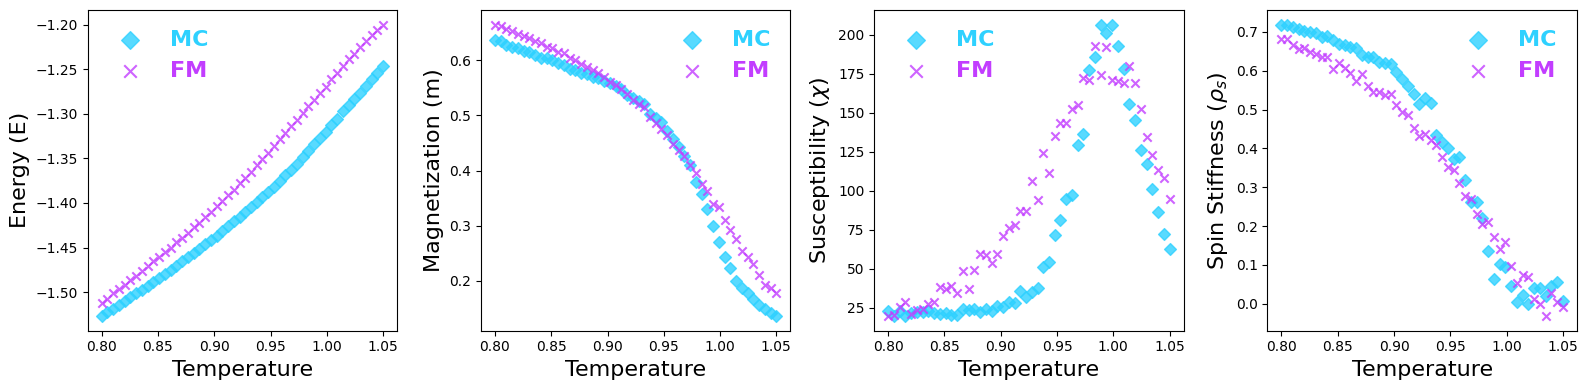

In [54]:
plt.style.use('seaborn-v0_8-pastel')

mc_color = "#2ED1FF"
fm_color = '#C23DFF'

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].scatter(mc_size_128_temperature, mc_size_128_energy, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[0].scatter(Temp_128.cpu(), fm_energy_size_128, marker='x', label='FM', color=fm_color, alpha=0.8)
ax[0].set_ylabel('Energy (E)', fontsize=16)
# ax[0].set_title('Energy', fontsize=16)

ax[1].scatter(mc_size_128_temperature, mc_size_128_magnetization, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[1].scatter(Temp_128.cpu(), fm_magnetization_size_128, marker='x', label='FM', color=fm_color, alpha=0.8)
ax[1].set_ylabel('Magnetization (m)', fontsize=16)
# ax[1].set_title('Magnetization', fontsize=16)

ax[2].scatter(mc_size_128_temperature, mc_size_128_susceptibility, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[2].scatter(Temp_128.cpu(), fm_susceptibility_size_128, marker='x', label='FM', color=fm_color, alpha=0.8)
ax[2].set_ylabel(r'Susceptibility ($\chi$)', fontsize=16)
# ax[2].set_title('Susceptibility', fontsize=16)

ax[3].scatter(mc_size_128_temperature, mc_size_128_stiffness, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[3].scatter(Temp_128.cpu(), fm_stiffness_size_128, marker='x', label='FM', color=fm_color, alpha=0.8)
ax[3].set_ylabel(r'Spin Stiffness ($\rho_s$)', fontsize=16)
# ax[3].set_title('Spin Stiffness', fontsize=16)

for i in range(4):
    ax[i].set_xlabel('Temperature', fontsize=16)
    ax[i].legend(
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_color, fm_color],
        markerscale=1.5,
        frameon=False
    )
plt.tight_layout()
plt.show()

In [55]:
trash.append(sampler_xy)
pf.clear_cuda_cache(trash)
trash = []

### Compare the results between flow matching and Monte Carlo at different system sizes

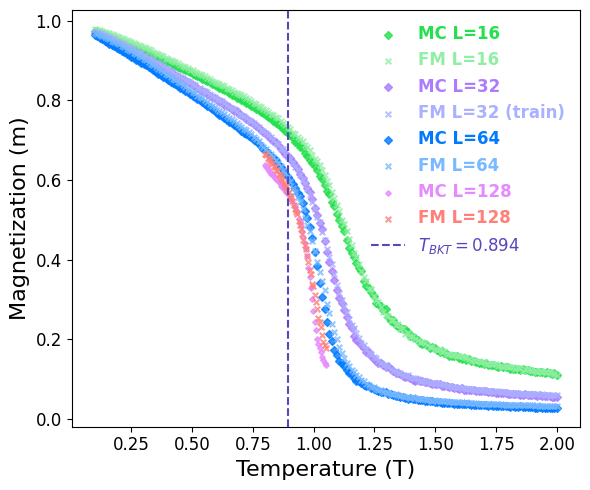

In [56]:
plt.style.use('seaborn-v0_8-pastel')

mc_16_color = "#24E04C"
fm_16_color = '#91EFA5'

mc_32_color = "#AC7CFF"
fm_32_color = '#AAB1FF'

mc_64_color = "#017AFF"
fm_64_color = '#79B9FF'

mc_128_color = "#E68BFF"
fm_128_color = '#FF7F79'

s = 16
tc_bkt = 0.894

fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(mc_size_16_temperature, mc_size_16_magnetization, marker='D', label='MC L=16', color=mc_16_color, alpha=0.8, s=s)
ax.scatter(Temp.cpu(), fm_magnetization_size_16, marker='x', label='FM L=16', color=fm_16_color, alpha=0.8, s=s)
ax.scatter(mc_size_32_temperature, mc_size_32_magnetization, marker='D', label='MC L=32', color=mc_32_color, alpha=0.8, s=s)
ax.scatter(Temp.cpu(), fm_magnetization_size_32, marker='x', label='FM L=32 (train)', color=fm_32_color, alpha=0.8, s=s)
ax.scatter(mc_size_64_temperature, mc_size_64_magnetization, marker='D', label='MC L=64', color=mc_64_color, alpha=0.8, s=s)
ax.scatter(Temp.cpu(), fm_magnetization_size_64, marker='x', label='FM L=64', color=fm_64_color, alpha=0.8, s=s)
ax.scatter(mc_size_128_temperature, mc_size_128_magnetization, marker='D', label='MC L=128', color=mc_128_color, alpha=0.8, s=0.5*s)
ax.scatter(Temp_128.cpu(), fm_magnetization_size_128, marker='x', label='FM L=128', color=fm_128_color, alpha=0.8, s=s)
ax.axvline(tc_bkt, linestyle='--', label=f'$T_{{BKT}}={tc_bkt:.3f}$', color='#5945BF')
ax.set_ylabel('Magnetization (m)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
# ax.set_title('Magnetization', fontsize=16)

ax.set_xlabel('Temperature (T)', fontsize=16)
ax.legend(
    prop={'weight': 'bold', 'size': 12},
    labelcolor=[
        mc_16_color, fm_16_color,
        mc_32_color, fm_32_color,
        mc_64_color, fm_64_color,
        mc_128_color, fm_128_color,
        '#5945BF'
    ],
    markerscale=1.0,
    frameon=False
)
plt.tight_layout()
plt.show()

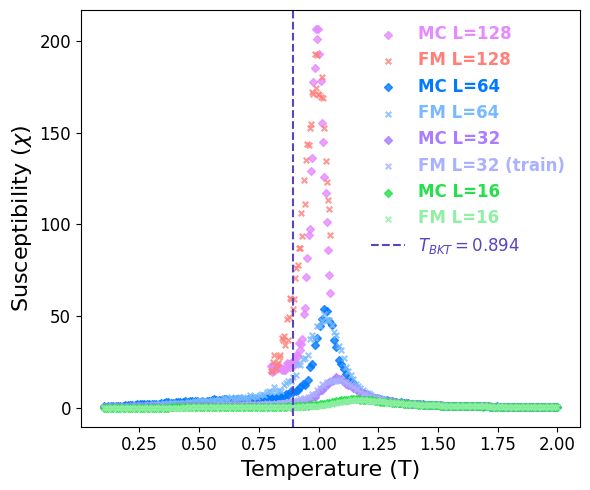

In [57]:
plt.style.use('seaborn-v0_8-pastel')

mc_16_color = "#24E04C"
fm_16_color = '#91EFA5'

mc_32_color = "#AC7CFF"
fm_32_color = '#AAB1FF'

mc_64_color = "#017AFF"
fm_64_color = '#79B9FF'

mc_128_color = "#E68BFF"
fm_128_color = '#FF7F79'

s = 16
tc_bkt = 0.894

fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(mc_size_128_temperature, mc_size_128_susceptibility, marker='D', label='MC L=128', color=mc_128_color, alpha=0.8, s=s)
ax.scatter(Temp_128.cpu(), fm_susceptibility_size_128, marker='x', label='FM L=128', color=fm_128_color, alpha=0.8, s=s)
ax.scatter(mc_size_64_temperature, mc_size_64_susceptibility, marker='D', label='MC L=64', color=mc_64_color, alpha=0.8, s=s)
ax.scatter(Temp.cpu(), fm_susceptibility_size_64, marker='x', label='FM L=64', color=fm_64_color, alpha=0.8, s=s)
ax.scatter(mc_size_32_temperature, mc_size_32_susceptibility, marker='D', label='MC L=32', color=mc_32_color, alpha=0.8, s=s)
ax.scatter(Temp.cpu(), fm_susceptibility_size_32, marker='x', label='FM L=32 (train)', color=fm_32_color, alpha=0.8, s=s)
ax.scatter(mc_size_16_temperature, mc_size_16_susceptibility, marker='D', label='MC L=16', color=mc_16_color, alpha=0.8, s=s)
ax.scatter(Temp.cpu(), fm_susceptibility_size_16, marker='x', label='FM L=16', color=fm_16_color, alpha=0.8, s=s)
ax.axvline(tc_bkt, linestyle='--', label=f'$T_{{BKT}}={tc_bkt:.3f}$', color='#5945BF')
ax.set_ylabel(r'Susceptibility ($\chi$)', fontsize=16)
# ax.set_title('Susceptibility', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel('Temperature (T)', fontsize=16)
ax.legend(
    prop={'weight': 'bold', 'size': 12},
    labelcolor=[
        mc_128_color, fm_128_color,
        mc_64_color, fm_64_color,
        mc_32_color, fm_32_color,
        mc_16_color, fm_16_color,
        '#5945BF'
    ],
    markerscale=1.0,
    frameon=False
)
plt.tight_layout()
plt.show()

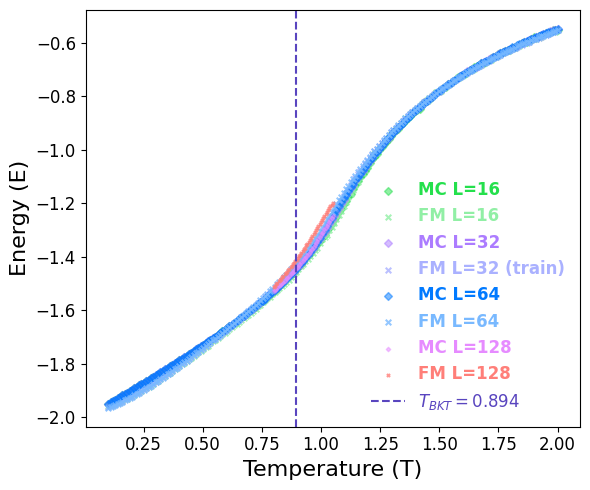

In [58]:
plt.style.use('seaborn-v0_8-pastel')

mc_16_color = "#24E04C"
fm_16_color = '#91EFA5'

mc_32_color = "#AC7CFF"
fm_32_color = '#AAB1FF'

mc_64_color = "#017AFF"
fm_64_color = '#79B9FF'

mc_128_color = "#E68BFF"
fm_128_color = '#FF7F79'

s = 16

fm_Temp_cpu = Temp.cpu()
max_temp = 1.5
mc_max_temp_index = len(mc_size_16_temperature[mc_size_16_temperature < max_temp]) - 1
fm_max_temp_index = len(fm_Temp_cpu[fm_Temp_cpu < max_temp]) - 1
tc_bkt = 0.894

fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(mc_size_16_temperature, mc_size_16_energy, marker='D', label='MC L=16', color=mc_16_color, alpha=0.5, s=s)
ax.scatter(Temp.cpu(), fm_energy_size_16, marker='x', label='FM L=16', color=fm_16_color, alpha=0.8, s=s)
ax.scatter(mc_size_32_temperature, mc_size_32_energy, marker='D', label='MC L=32', color=mc_32_color, alpha=0.5, s=s)
ax.scatter(Temp.cpu(), fm_energy_size_32, marker='x', label='FM L=32 (train)', color=fm_32_color, alpha=0.8, s=s)
ax.scatter(mc_size_64_temperature, mc_size_64_energy, marker='D', label='MC L=64', color=mc_64_color, alpha=0.5, s=s)
ax.scatter(Temp.cpu(), fm_energy_size_64, marker='x', label='FM L=64', color=fm_64_color, alpha=0.8, s=s)
ax.scatter(mc_size_128_temperature, mc_size_128_energy, marker='D', label='MC L=128', color=mc_128_color, alpha=0.5, s=0.3*s)
ax.scatter(Temp_128.cpu(), fm_energy_size_128, marker='x', label='FM L=128', color=fm_128_color, alpha=0.8, s=0.3*s)
ax.axvline(tc_bkt, linestyle='--', label=f'$T_{{BKT}}={tc_bkt:.3f}$', color='#5945BF')
ax.set_ylabel('Energy (E)', fontsize=16)
# ax.set_title('Energy', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel('Temperature (T)', fontsize=16)
ax.legend(
    prop={'weight': 'bold', 'size': 12},
    labelcolor=[
        mc_16_color, fm_16_color,
        mc_32_color, fm_32_color,
        mc_64_color, fm_64_color,
        mc_128_color, fm_128_color,
        '#5945BF'
    ],
    markerscale=1.0,
    frameon=False,
    loc='lower right',
)
plt.tight_layout()
plt.show()

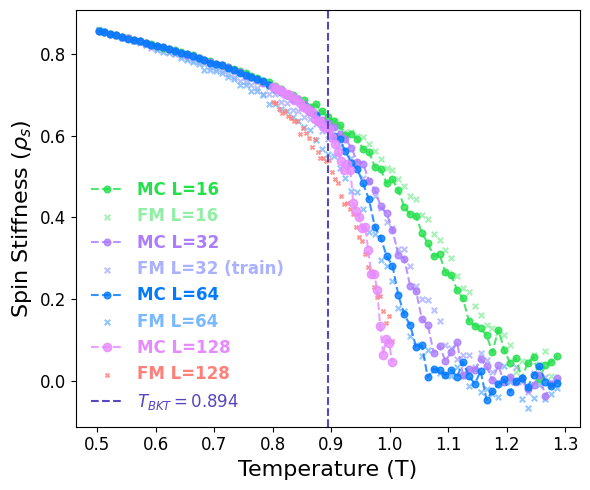

In [59]:
plt.style.use('seaborn-v0_8-pastel')

mc_16_color = "#24E04C"
fm_16_color = '#91EFA5'

mc_32_color = "#AC7CFF"
fm_32_color = '#AAB1FF'

mc_64_color = "#017AFF"
fm_64_color = '#79B9FF'

mc_128_color = "#E68BFF"
fm_128_color = '#FF7F79'

s = 16

fm_Temp_cpu = Temp.cpu()
max_temp = 1.3
min_temp = 0.5
mc_max_temp_index = len(mc_size_16_temperature[mc_size_16_temperature < max_temp]) - 1
mc_min_temp_index = len(mc_size_16_temperature) - len(mc_size_16_temperature[mc_size_16_temperature > min_temp])
fm_max_temp_index = len(fm_Temp_cpu[fm_Temp_cpu < max_temp]) - 1
fm_min_temp_index = len(fm_Temp_cpu) - len(fm_Temp_cpu[fm_Temp_cpu > min_temp])
tc_bkt = 0.894

fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(mc_size_16_temperature[mc_min_temp_index:mc_max_temp_index], mc_size_16_stiffness[mc_min_temp_index:mc_max_temp_index], marker='o', label='MC L=16', color=mc_16_color, alpha=0.8, linestyle='dashed', markersize=s*0.3)
ax.scatter(fm_Temp_cpu[fm_min_temp_index:fm_max_temp_index], fm_stiffness_size_16[fm_min_temp_index:fm_max_temp_index], marker='x', label='FM L=16', color=fm_16_color, alpha=0.8, s=s)
ax.plot(mc_size_32_temperature[mc_min_temp_index:mc_max_temp_index], mc_size_32_stiffness[mc_min_temp_index:mc_max_temp_index], marker='o', label='MC L=32', color=mc_32_color, alpha=0.8, linestyle='dashed', markersize=s*0.3)
ax.scatter(fm_Temp_cpu[fm_min_temp_index:fm_max_temp_index], fm_stiffness_size_32[fm_min_temp_index:fm_max_temp_index], marker='x', label='FM L=32 (train)', color=fm_32_color, alpha=0.8, s=s)
ax.plot(mc_size_64_temperature[mc_min_temp_index:mc_max_temp_index], mc_size_64_stiffness[mc_min_temp_index:mc_max_temp_index], marker='o', label='MC L=64', color=mc_64_color, alpha=0.8, linestyle='dashed', markersize=s*0.3)
ax.scatter(fm_Temp_cpu[fm_min_temp_index:fm_max_temp_index], fm_stiffness_size_64[fm_min_temp_index:fm_max_temp_index], marker='x', label='FM L=64', color=fm_64_color, alpha=0.8, s=s)
ax.plot(mc_size_128_temperature[:-9], mc_size_128_stiffness[:-9], marker='o', label='MC L=128', color=mc_128_color, alpha=0.8, linestyle='dashed')
ax.scatter(Temp_128.cpu()[:-9], fm_stiffness_size_128[:-9], marker='x', label='FM L=128', color=fm_128_color, alpha=0.8, s=0.5 * s)
ax.axvline(tc_bkt, linestyle='--', label=f'$T_{{BKT}}={tc_bkt:.3f}$', color='#5945BF')
ax.set_ylabel(r'Spin Stiffness ($\rho_s$)', fontsize=16)
# ax.set_title('Spin Stiffness', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel('Temperature (T)', fontsize=16)
ax.legend(
    prop={'weight': 'bold', 'size': 12},
    labelcolor=[
        mc_16_color, fm_16_color,
        mc_32_color, fm_32_color,
        mc_64_color, fm_64_color,
        mc_128_color, fm_128_color,
        '#5945BF'
    ],
    markerscale=1.0,
    frameon=False,
    loc='lower left',
)
plt.tight_layout()
plt.show()

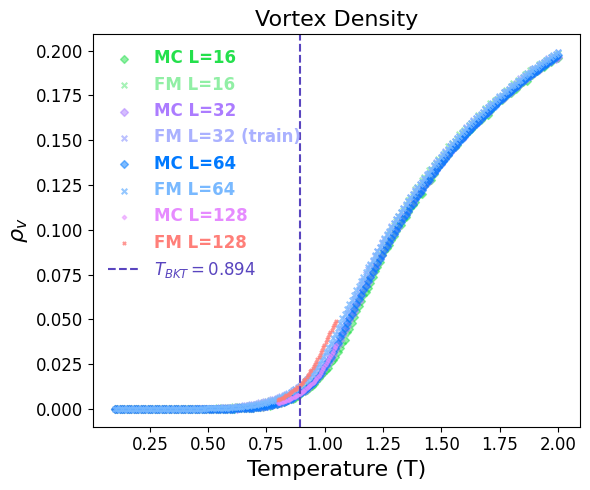

In [60]:
plt.style.use('seaborn-v0_8-pastel')

mc_16_color = "#24E04C"
fm_16_color = '#91EFA5'

mc_32_color = "#AC7CFF"
fm_32_color = '#AAB1FF'

mc_64_color = "#017AFF"
fm_64_color = '#79B9FF'

mc_128_color = "#E68BFF"
fm_128_color = '#FF7F79'

s = 16

fm_Temp_cpu = Temp.cpu()
max_temp = 1.5
mc_max_temp_index = len(mc_size_16_temperature[mc_size_16_temperature < max_temp]) - 1
fm_max_temp_index = len(fm_Temp_cpu[fm_Temp_cpu < max_temp]) - 1
tc_bkt = 0.894

fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(mc_size_16_temperature, mc_size_16_vortex_density, marker='D', label='MC L=16', color=mc_16_color, alpha=0.5, s=s)
ax.scatter(Temp.cpu(), fm_vortex_density_size_16, marker='x', label='FM L=16', color=fm_16_color, alpha=0.8, s=s)
ax.scatter(mc_size_32_temperature, mc_size_32_vortex_density, marker='D', label='MC L=32', color=mc_32_color, alpha=0.5, s=s)
ax.scatter(Temp.cpu(), fm_vortex_density_size_32, marker='x', label='FM L=32 (train)', color=fm_32_color, alpha=0.8, s=s)
ax.scatter(mc_size_64_temperature, mc_size_64_vortex_density, marker='D', label='MC L=64', color=mc_64_color, alpha=0.5, s=s)
ax.scatter(Temp.cpu(), fm_vortex_density_size_64, marker='x', label='FM L=64', color=fm_64_color, alpha=0.8, s=s)
ax.scatter(mc_size_128_temperature, mc_size_128_vortex_density, marker='D', label='MC L=128', color=mc_128_color, alpha=0.5, s=0.3*s)
ax.scatter(Temp_128.cpu(), fm_vortex_density_size_128, marker='x', label='FM L=128', color=fm_128_color, alpha=0.8, s=0.3*s)
ax.axvline(tc_bkt, linestyle='--', label=f'$T_{{BKT}}={tc_bkt:.3f}$', color='#5945BF')
ax.set_ylabel(r'$\rho_v$', fontsize=16)
ax.set_title('Vortex Density', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel('Temperature (T)', fontsize=16)
ax.legend(
    prop={'weight': 'bold', 'size': 12},
    labelcolor=[
        mc_16_color, fm_16_color,
        mc_32_color, fm_32_color,
        mc_64_color, fm_64_color,
        mc_128_color, fm_128_color,
        '#5945BF'
    ],
    markerscale=1.0,
    frameon=False,
    loc='upper left',
)
plt.tight_layout()
plt.show()

### Finite size scaling

In [61]:
fs_L_list          = [   16,    20,    24,    28,    32,    40,    48,    64,    80,    96]
fs_Temp_start_list = [1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 0.950, 0.950]
fs_Temp_end_list   = [1.200, 1.200, 1.200, 1.200, 1.200, 1.200, 1.200, 1.100, 1.050, 1.050]
fs_precision = 0.001
fs_num_samples = 1500
num_steps = 5
timestep_schedule_mu = -0.3
timestep_schedule_sigma = 1.0

fs_num_temp_list = [int((end-start)//fs_precision)+1 for (end, start) in zip(fs_Temp_end_list, fs_Temp_start_list)]

T_peak_chi_list = []

for index, fs_L in enumerate(fs_L_list):
    B_opt = pf.estimate_max_batch_size(
        model = model,
        num_data=fs_num_temp_list[index] * fs_num_samples,
        channels=1,
        height=fs_L,
        width=fs_L,
        time_steps=num_steps,
        num_conditions=num_conditions,
        num_evals=3,
        device=device,
        use_adjoint=False,
        safety_factor=0.9
    )
    print(f"Optimal batch size: {B_opt}")
    B_opt_mod = pf.find_closest_factor(fs_num_temp_list[index] * fs_num_samples, B_opt)
    print(f"Optimal batch size (modify): {B_opt_mod}")

    fs_Temp = torch.linspace(fs_Temp_start_list[index], fs_Temp_end_list[index], steps=fs_num_temp_list[index])
    x_init = torch.randn((fs_num_temp_list[index], fs_num_samples, fs_L, fs_L), dtype=torch.float32)

    xy_inference_dataset = mc.MCDataset(data=x_init, labels=fs_Temp)
    xy_inference_dataloader = DataLoader(xy_inference_dataset, batch_size=B_opt_mod, shuffle=False)

    torch.cuda.empty_cache()
    torch.cuda.synchronize(device)

    _ = fmex.solve(
        solve_loader=xy_inference_dataloader,
        num_samples=fs_num_samples,
        num_steps=10,
        for_gpu_warmup=True,
        do_log=False,
    )

    fs_sol = fmex.solve(
        solve_loader=xy_inference_dataloader,
        num_samples=fs_num_samples,
        num_steps=num_steps,
        method='heun3',
        timestep_schedule_mu=timestep_schedule_mu,
        timestep_schedule_sigma=timestep_schedule_sigma,
        do_log=False,
    )
    torch.cuda.empty_cache()

    sampler_xy = mc.XYModel(
        L=fs_L,
        T=fs_Temp,
        device=torch.device(device),
        use_amp=True
    )

    sampler_xy.spins = fs_sol * torch.pi + torch.pi  # Shift to [0, 2π) range.
    trash.append(fs_sol)

    T_peak_chi_list.append(fs_Temp[np.argmax(sampler_xy.compute_susceptibility().cpu().numpy())])

    trash.append(sampler_xy)
    pf.clear_cuda_cache(trash)
    trash = []
    torch.cuda.synchronize(device)


Optimal batch size: 1800
Optimal batch size (modify): 1875


2025-12-30 04:02:12,501 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 04:02:13,236 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=16, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 1160
Optimal batch size (modify): 1200


2025-12-30 04:02:56,034 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 04:02:56,745 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=20, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 809
Optimal batch size (modify): 800


2025-12-30 04:04:05,133 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 04:04:05,745 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=24, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 596
Optimal batch size (modify): 600


2025-12-30 04:05:40,042 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 04:05:40,681 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=28, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 457
Optimal batch size (modify): 480


2025-12-30 04:07:49,327 - INFO - Performing GPU warmup. No actual sampling will be done.
Solving ODE (Sampling):   0%|          | 0/625 [00:00<?, ?it/s]AUTOTUNE convolution(480x64x8x8, 256x64x1x1)
  convolution 0.0666 ms 100.0% 
  triton_convolution2d_379 0.0694 ms 95.9% ALLOW_TF32=True, BLOCK_K=32, BLOCK_M=64, BLOCK_N=256, GROUPS=1, KERNEL_H=1, KERNEL_W=1, PADDING_H=0, PADDING_W=0, STRIDE_H=1, STRIDE_W=1, UNROLL=True, num_stages=2, num_warps=8
  triton_convolution2d_375 0.0697 ms 95.5% ALLOW_TF32=True, BLOCK_K=16, BLOCK_M=256, BLOCK_N=64, GROUPS=1, KERNEL_H=1, KERNEL_W=1, PADDING_H=0, PADDING_W=0, STRIDE_H=1, STRIDE_W=1, UNROLL=True, num_stages=2, num_warps=4
  triton_convolution2d_378 0.0717 ms 92.9% ALLOW_TF32=True, BLOCK_K=32, BLOCK_M=64, BLOCK_N=64, GROUPS=1, KERNEL_H=1, KERNEL_W=1, PADDING_H=0, PADDING_W=0, STRIDE_H=1, STRIDE_W=1, UNROLL=True, num_stages=2, num_warps=4
  triton_convolution2d_377 0.0727 ms 91.6% ALLOW_TF32=True, BLOCK_K=32, BLOCK_M=128, BLOCK_N=128, GROUPS=1, KERN

Initialized MonteCarloSampler on device: cuda:0
 L=32, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 293
Optimal batch size (modify): 300


2025-12-30 04:10:32,182 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 04:10:32,939 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=40, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 203
Optimal batch size (modify): 200


2025-12-30 04:14:45,360 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 04:14:46,197 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=48, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 114
Optimal batch size (modify): 125


2025-12-30 04:20:46,804 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 04:20:47,583 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=64, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 73
Optimal batch size (modify): 75


2025-12-30 04:26:18,123 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 04:26:18,890 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=80, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 51
Optimal batch size (modify): 50


2025-12-30 04:35:20,218 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 04:35:21,091 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=96, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False


In [62]:
fs_L_list.append(128)
fs_L_list

[16, 20, 24, 28, 32, 40, 48, 64, 80, 96, 128]

In [63]:
T_peak_128 = float(Temp_128[np.argmax(fm_susceptibility_size_128)])
T_peak_chi = [float(T_peak.cpu().numpy()) for T_peak in T_peak_chi_list]
T_peak_chi.append(T_peak_128)
T_peak_128

0.9836734533309937

In [64]:
fs_L = np.array(fs_L_list, dtype=float)
T_peak_chi = np.array(T_peak_chi)

print(fs_L)
print(T_peak_chi)

[ 16.  20.  24.  28.  32.  40.  48.  64.  80.  96. 128.]
[1.18190956 1.13165832 1.10954773 1.08643222 1.06532669 1.06633162
 1.03618085 1.02600002 1.01800001 1.00599992 0.98367345]


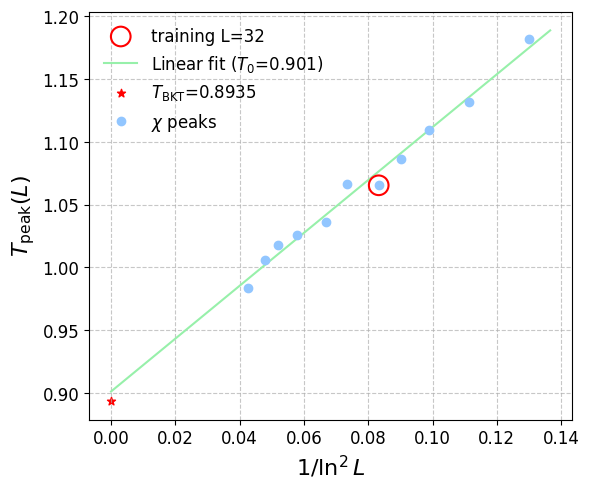

In [65]:

# -------------------------------------------------------------------------
#                   FINITE‑SIZE‑SCALING MODELS
# -------------------------------------------------------------------------
# def t_peak_ansatz(L, T_bkt, A, L0):
#     """BKT finite‑size scaling:  T(L) = T_bkt + A / ln^2(L / L0)."""
#     return T_bkt + A / np.log(L / L0) ** 2


x = 1.0 / np.log(fs_L) ** 2
p_lin_chi  = np.polyfit(x, T_peak_chi, 1)
T_lin_chi  = p_lin_chi[1]

training_size_L = 32
training_size_index = np.where(fs_L == training_size_L)[0][0]
x_highlight = x[training_size_index]
y_highlight = T_peak_chi[training_size_index]
x_highlight_bkt = 0.0
y_highlight_bkt = 0.8935

# Linearised 1/ln^2(L) vs T peaks
fig, ax = plt.subplots(figsize=(6, 5))
ax.errorbar(x, T_peak_chi,  fmt='o', label=r'$\chi$ peaks')
ax.scatter(x_highlight, y_highlight, s=200, facecolors='none', edgecolors='red', linewidths=1.5, zorder=5, label=f'training L={training_size_L}')
x_fit = np.linspace(0, x.max()*1.05, 200)
ax.plot(x_fit, np.polyval(p_lin_chi,  x_fit),  label=f'Linear fit ($T_0$={T_lin_chi:.3f})')
ax.scatter(x_highlight_bkt, y_highlight_bkt, color='red', marker='*', label=r'$T_{\mathrm{BKT}}$=0.8935')
ax.set_xlabel(r'$1/\ln^2 L$', fontsize=16)
ax.set_ylabel(r'$T_{\mathrm{peak}}(L)$', fontsize=16)
# ax.set_title(r'FM finite‑size scaling of $\chi$ peak temperatures', fontsize=16)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, prop={'size': 12}, markerscale=1.0, frameon=False, loc='upper left')
ax.tick_params(axis='both', which='major', labelsize=12)

ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

### Error analysis.

In [66]:
def mse_mae_estimator(fm_data_list, mc_data_list, precision_modify_list):
    """
    Calculate the MSE and MAE between flow matching and Monte Carlo data.

    Args:
        fm_data_list (list): List of flow matching data tensors.
        mc_data_list (list): List of Monte Carlo data tensors.

    Returns:
        tuple: MSE and MAE values.
    """
    mse_list = []
    mae_list = []

    for index, (fm_data, mc_data) in enumerate(zip(fm_data_list, mc_data_list)):
        fm_tensor = torch.tensor(fm_data[::precision_modify_list[index]])  # Reduce by factor of 5
        mc_tensor = torch.tensor(mc_data)

        mse = torch.nn.functional.mse_loss(fm_tensor, mc_tensor)
        mae = torch.nn.functional.l1_loss(fm_tensor, mc_tensor)

        mse_list.append(mse.item())
        mae_list.append(mae.item())

    return mse_list, mae_list

In [67]:
precision_modify_list = [
    1,
    1,
    1,
    1
]

fm_energy_list = [
    fm_energy_size_16,
    fm_energy_size_32,
    fm_energy_size_64,
    fm_energy_size_128,
]
mc_energy_list = [
    mc_size_16_energy,
    mc_size_32_energy,
    mc_size_64_energy,
    mc_size_128_energy,
]
mse_energy, mae_energy = mse_mae_estimator(fm_energy_list, mc_energy_list, precision_modify_list)

fm_stiffness_list = [
    fm_stiffness_size_16,
    fm_stiffness_size_32,
    fm_stiffness_size_64,
    fm_stiffness_size_128,
]
mc_stiffness_list = [
    mc_size_16_stiffness,
    mc_size_32_stiffness,
    mc_size_64_stiffness,
    mc_size_128_stiffness,
]
mse_stiffness, mae_stiffness = mse_mae_estimator(fm_stiffness_list, mc_stiffness_list, precision_modify_list)

fm_magnetization_list = [
    fm_magnetization_size_16,
    fm_magnetization_size_32,
    fm_magnetization_size_64,
    fm_magnetization_size_128,
]
mc_magnetization_list = [
    mc_size_16_magnetization,
    mc_size_32_magnetization,
    mc_size_64_magnetization,
    mc_size_128_magnetization,
]
mse_magnetization, mae_magnetization = mse_mae_estimator(fm_magnetization_list, mc_magnetization_list, precision_modify_list)

fm_susceptibility_list = [
    fm_susceptibility_size_16,
    fm_susceptibility_size_32,
    fm_susceptibility_size_64,
    fm_susceptibility_size_128,
]
mc_susceptibility_list = [
    mc_size_16_susceptibility,
    mc_size_32_susceptibility,
    mc_size_64_susceptibility,
    mc_size_128_susceptibility,
]
mse_susceptibility, mae_susceptibility = mse_mae_estimator(fm_susceptibility_list, mc_susceptibility_list, precision_modify_list)

fm_vortex_density_list = [
    fm_vortex_density_size_16,
    fm_vortex_density_size_32,
    fm_vortex_density_size_64,
    fm_vortex_density_size_128,
]
mc_vortex_density_list = [
    mc_size_16_vortex_density,
    mc_size_32_vortex_density,
    mc_size_64_vortex_density,
    mc_size_128_vortex_density,
]
mse_vortex_density, mae_vortex_density = mse_mae_estimator(fm_vortex_density_list, mc_vortex_density_list, precision_modify_list)

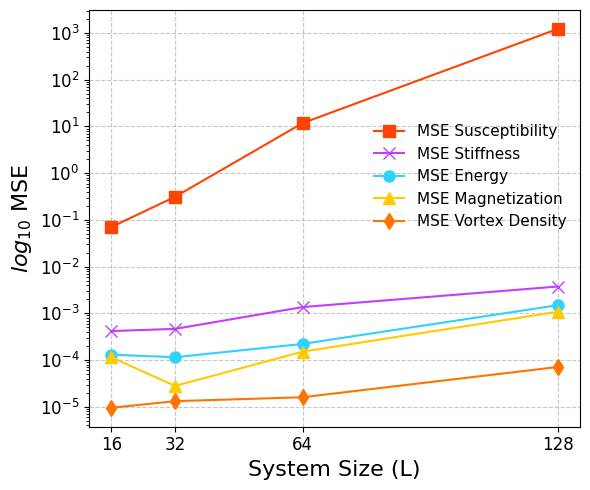

In [68]:
system_size_list = [
    16,
    32,
    64,
    128
]

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(system_size_list, mse_susceptibility, marker='s', label='MSE Susceptibility', color='#FF4300', markersize=8)
ax.plot(system_size_list, mse_stiffness, marker='x', label='MSE Stiffness', color='#C23DFF', markersize=8)
ax.plot(system_size_list, mse_energy, marker='o', label='MSE Energy', color='#2ED1FF', markersize=8)
ax.plot(system_size_list, mse_magnetization, marker='^', label='MSE Magnetization', color='#FFCB00', markersize=8)
ax.plot(system_size_list, mse_vortex_density, marker='d', label='MSE Vortex Density', color='#FF7400', markersize=8)
ax.set_xlabel('System Size (L)', fontsize=16)
ax.set_ylabel(r'$log_{10}$ MSE', fontsize=16)
# ax.set_title('MSE over Temperature Between FM & MC', fontsize=16)
ax.set_xticks(system_size_list)
ax.set_xticklabels(system_size_list, fontsize=14)
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(
    prop={'size': 11},
    bbox_to_anchor=(1.0, 0.6),
    loc='right',
    frameon=False
)
ax.grid(True, linestyle='--', alpha=0.7)

# ax.plot(system_size_list, mae_energy, marker='o', label='MAE Energy', color='#2ED1FF', markersize=8)
# ax.plot(system_size_list, mae_stiffness, marker='x', label='MAE Stiffness', color='#C23DFF', markersize=8)
# ax.plot(system_size_list, mae_magnetization, marker='^', label='MAE Magnetization', color='#FFCB00', markersize=8)
# ax.plot(system_size_list, mae_susceptibility, marker='s', label='MAE Susceptibility', color='#FF4300', markersize=8)
# ax.plot(system_size_list, mae_vortex_density, marker='d', label='MAE Vortex Density', color='#FF7400', markersize=8)
# ax.set_xlabel('System Size (L)', fontsize=16)
# ax.set_ylabel(r'$log_{10}$ MAE', fontsize=16)
# ax.set_title('MAE over Temperature Between FM & MC', fontsize=16)
# ax.set_xticks(system_size_list)
# ax.set_xticklabels(system_size_list, fontsize=14)
# ax.set_yscale('log')
# ax.legend(
#     prop={'weight': 'bold', 'size': 11},
#     loc='right',
#     frameon=False
# )

plt.tight_layout()
plt.show()

### Compare the simulation time between flow matching and Monte Carlo at different system sizes

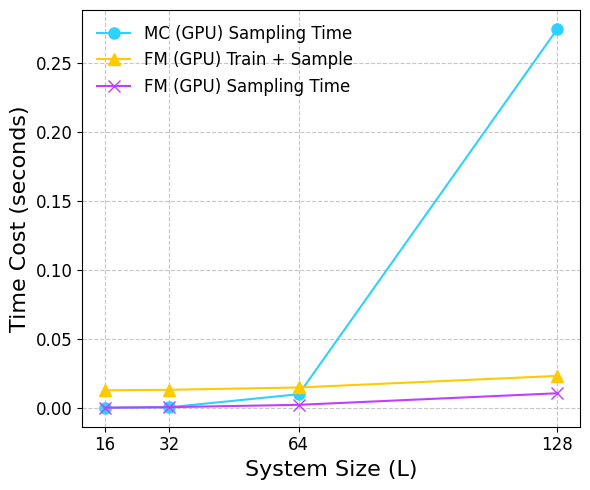

In [69]:
system_size_list = [
    16,
    32,
    64,
    128
]
mc_sample_time_list = [
    mc_size_16_time_per_sample,
    mc_size_32_time_per_sample,
    mc_size_64_time_per_sample,
    mc_size_128_time_per_sample,
]
fm_sample_time_list = [
    sol_size_16_time_per_sample,
    sol_size_32_time_per_sample,
    sol_size_64_time_per_sample,
    sol_size_128_time_per_sample,
]
fm_train_sample_time_list =[
    train_sol_size_16_time_per_sample,
    train_sol_size_32_time_per_sample,
    train_sol_size_64_time_per_sample,
    train_sol_size_128_time_per_sample,
]

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(system_size_list, mc_sample_time_list, marker='o', label='MC (GPU) Sampling Time', color='#2ED1FF', markersize=8)
ax.plot(system_size_list, fm_train_sample_time_list, marker='^', label='FM (GPU) Train + Sample', color='#FFCB00', markersize=8)
ax.plot(system_size_list, fm_sample_time_list, marker='x', label='FM (GPU) Sampling Time', color='#C23DFF', markersize=8)
ax.set_xlabel('System Size (L)', fontsize=16)
ax.set_ylabel('Time Cost (seconds)', fontsize=16)
# ax.set_title('Comparison of Time Cost per Sample', fontsize=16)
ax.set_xticks(system_size_list)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(
    prop={'size': 12},
    loc='upper left',
    frameon=False
)
# ax.set_yscale('log')
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

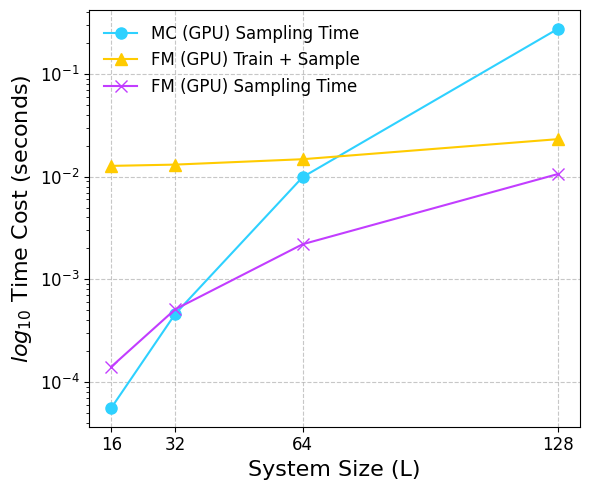

In [70]:
system_size_list = [
    16,
    32,
    64,
    128
]
mc_sample_time_list = [
    mc_size_16_time_per_sample,
    mc_size_32_time_per_sample,
    mc_size_64_time_per_sample,
    mc_size_128_time_per_sample,
]
fm_sample_time_list = [
    sol_size_16_time_per_sample,
    sol_size_32_time_per_sample,
    sol_size_64_time_per_sample,
    sol_size_128_time_per_sample,
]
fm_train_sample_time_list =[
    train_sol_size_16_time_per_sample,
    train_sol_size_32_time_per_sample,
    train_sol_size_64_time_per_sample,
    train_sol_size_128_time_per_sample,
]

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(system_size_list, mc_sample_time_list, marker='o', label='MC (GPU) Sampling Time', color='#2ED1FF', markersize=8)
ax.plot(system_size_list, fm_train_sample_time_list, marker='^', label='FM (GPU) Train + Sample', color='#FFCB00', markersize=8)
ax.plot(system_size_list, fm_sample_time_list, marker='x', label='FM (GPU) Sampling Time', color='#C23DFF', markersize=8)
ax.set_xlabel('System Size (L)', fontsize=16)
ax.set_ylabel(r'$log_{10}$ Time Cost (seconds)', fontsize=16)
# ax.set_title('Comparison of Time Cost per Sample', fontsize=16)
ax.set_xticks(system_size_list)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(
    prop={'size': 12},
    loc='upper left',
    frameon=False
)
ax.set_yscale('log')
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Finite size scaling with error bar

In [71]:
print(fs_L)
print(T_peak_chi)

[ 16.  20.  24.  28.  32.  40.  48.  64.  80.  96. 128.]
[1.18190956 1.13165832 1.10954773 1.08643222 1.06532669 1.06633162
 1.03618085 1.02600002 1.01800001 1.00599992 0.98367345]


In [72]:
bin_number = 10
T_peak_chi_array = np.zeros((len(fs_L), bin_number))
T_peak_chi_array[:,0] = T_peak_chi
T_peak_chi_array[:,0]

array([1.18190956, 1.13165832, 1.10954773, 1.08643222, 1.06532669,
       1.06633162, 1.03618085, 1.02600002, 1.01800001, 1.00599992,
       0.98367345])

In [73]:
fs_L_list          = [   16,    20,    24,    28,    32,    40,    48,    64,    80,    96,  128]
fs_Temp_start_list = [1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 0.950, 0.950, 0.960]
fs_Temp_end_list   = [1.200, 1.200, 1.200, 1.200, 1.200, 1.200, 1.200, 1.100, 1.050, 1.050, 1.010]
fs_precision = 0.001
fs_num_samples = [1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1000]
num_steps = 5
timestep_schedule_mu = -0.3
timestep_schedule_sigma = 1.0

fs_num_temp_list = [int((end-start)//fs_precision)+1 for (end, start) in zip(fs_Temp_end_list, fs_Temp_start_list)]

for bin_ in range(bin_number-1):
    T_peak_chi_list = []
    for index, L_ in enumerate(fs_L_list):
        B_opt = pf.estimate_max_batch_size(
            model = model,
            num_data=fs_num_temp_list[index] * fs_num_samples[index],
            channels=1,
            height=L_,
            width=L_,
            time_steps=num_steps,
            num_conditions=num_conditions,
            num_evals=3,
            device=device,
            use_adjoint=False,
            safety_factor=0.9
        )
        print(f"Optimal batch size: {B_opt}")
        B_opt_mod = pf.find_closest_factor(fs_num_temp_list[index] * fs_num_samples[index], B_opt)
        print(f"Optimal batch size (modify): {B_opt_mod}")

        fs_Temp = torch.linspace(fs_Temp_start_list[index], fs_Temp_end_list[index], steps=fs_num_temp_list[index])
        x_init = torch.randn((fs_num_temp_list[index], fs_num_samples[index], L_, L_), dtype=torch.float32)

        xy_inference_dataset = mc.MCDataset(data=x_init, labels=fs_Temp)
        xy_inference_dataloader = DataLoader(xy_inference_dataset, batch_size=B_opt_mod, shuffle=False)

        torch.cuda.empty_cache()
        torch.cuda.synchronize(device)

        _ = fmex.solve(
            solve_loader=xy_inference_dataloader,
            num_samples=fs_num_samples[index],
            num_steps=10,
            for_gpu_warmup=True,
            do_log=False,
        )

        fs_sol = fmex.solve(
            solve_loader=xy_inference_dataloader,
            num_samples=fs_num_samples[index],
            num_steps=num_steps,
            method='heun3',
            timestep_schedule_mu=timestep_schedule_mu,
            timestep_schedule_sigma=timestep_schedule_sigma,
            do_log=False,
        )
        torch.cuda.empty_cache()

        sampler_xy = mc.XYModel(
            L=L_,
            T=fs_Temp,
            device=torch.device(device),
            use_amp=True
        )

        sampler_xy.spins = fs_sol * torch.pi + torch.pi  # Shift to [0, 2π) range.
        trash.append(fs_sol)

        T_peak_chi_list.append(fs_Temp[np.argmax(sampler_xy.compute_susceptibility().cpu().numpy())])

        trash.append(sampler_xy)
        pf.clear_cuda_cache(trash)
        trash = []
        torch.cuda.synchronize(device)

    T_peak_chi_array[:,bin_+1] = T_peak_chi_list


Optimal batch size: 1800
Optimal batch size (modify): 1875


2025-12-30 04:49:08,389 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 04:49:09,284 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=16, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 1160
Optimal batch size (modify): 1200


2025-12-30 04:49:52,880 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 04:49:53,606 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=20, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 809
Optimal batch size (modify): 800


2025-12-30 04:51:01,970 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 04:51:02,759 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=24, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 596
Optimal batch size (modify): 600


2025-12-30 04:52:37,015 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 04:52:37,655 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=28, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 457
Optimal batch size (modify): 480


2025-12-30 04:54:45,560 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 04:54:46,189 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=32, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 293
Optimal batch size (modify): 300


2025-12-30 04:57:19,853 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 04:57:20,508 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=40, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 203
Optimal batch size (modify): 200


2025-12-30 05:01:31,837 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 05:01:32,610 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=48, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 114
Optimal batch size (modify): 125


2025-12-30 05:07:33,148 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 05:07:33,860 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=64, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 73
Optimal batch size (modify): 75


2025-12-30 05:13:03,383 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 05:13:04,109 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=80, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 51
Optimal batch size (modify): 50


2025-12-30 05:22:05,096 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 05:22:05,866 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=96, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 28
Optimal batch size (modify): 30


2025-12-30 05:35:51,830 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 05:35:52,730 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=128, BatchSize=51, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 1800
Optimal batch size (modify): 1875


2025-12-30 05:45:09,846 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 05:45:10,459 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=16, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 1160
Optimal batch size (modify): 1200


2025-12-30 05:45:53,222 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 05:45:53,917 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=20, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 809
Optimal batch size (modify): 800


2025-12-30 05:47:02,126 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 05:47:02,980 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=24, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 596
Optimal batch size (modify): 600


2025-12-30 05:48:37,150 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 05:48:37,824 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=28, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 457
Optimal batch size (modify): 480


2025-12-30 05:50:45,442 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 05:50:46,088 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=32, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 293
Optimal batch size (modify): 300


2025-12-30 05:53:20,591 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 05:53:21,224 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=40, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 203
Optimal batch size (modify): 200


2025-12-30 05:57:32,333 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 05:57:33,105 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=48, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 114
Optimal batch size (modify): 125


2025-12-30 06:03:33,178 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 06:03:34,031 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=64, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 73
Optimal batch size (modify): 75


2025-12-30 06:09:03,917 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 06:09:04,656 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=80, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 51
Optimal batch size (modify): 50


2025-12-30 06:18:05,848 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 06:18:06,742 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=96, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 28
Optimal batch size (modify): 30


2025-12-30 06:31:53,751 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 06:31:54,785 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=128, BatchSize=51, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 1800
Optimal batch size (modify): 1875


2025-12-30 06:41:11,292 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 06:41:11,936 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=16, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 1160
Optimal batch size (modify): 1200


2025-12-30 06:41:54,581 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 06:41:55,280 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=20, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 809
Optimal batch size (modify): 800


2025-12-30 06:43:03,540 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 06:43:04,240 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=24, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 596
Optimal batch size (modify): 600


2025-12-30 06:44:38,472 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 06:44:39,159 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=28, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 457
Optimal batch size (modify): 480


2025-12-30 06:46:46,724 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 06:46:47,363 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=32, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 293
Optimal batch size (modify): 300


2025-12-30 06:49:21,407 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 06:49:22,092 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=40, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 203
Optimal batch size (modify): 200


2025-12-30 06:53:32,930 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 06:53:33,740 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=48, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 114
Optimal batch size (modify): 125


2025-12-30 06:59:32,765 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 06:59:33,426 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=64, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 73
Optimal batch size (modify): 75


2025-12-30 07:05:04,233 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 07:05:05,016 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=80, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 51
Optimal batch size (modify): 50


2025-12-30 07:14:04,270 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 07:14:05,097 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=96, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 28
Optimal batch size (modify): 30


2025-12-30 07:27:51,189 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 07:27:52,209 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=128, BatchSize=51, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 1800
Optimal batch size (modify): 1875


2025-12-30 07:37:09,074 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 07:37:09,765 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=16, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 1160
Optimal batch size (modify): 1200


2025-12-30 07:37:52,337 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 07:37:53,046 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=20, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 809
Optimal batch size (modify): 800


2025-12-30 07:39:01,307 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 07:39:02,133 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=24, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 596
Optimal batch size (modify): 600


2025-12-30 07:40:35,772 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 07:40:36,388 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=28, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 457
Optimal batch size (modify): 480


2025-12-30 07:42:44,567 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 07:42:45,188 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=32, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 293
Optimal batch size (modify): 300


2025-12-30 07:45:18,358 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 07:45:18,951 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=40, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 203
Optimal batch size (modify): 200


2025-12-30 07:49:30,556 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 07:49:31,351 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=48, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 114
Optimal batch size (modify): 125


2025-12-30 07:55:29,862 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 07:55:30,706 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=64, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 73
Optimal batch size (modify): 75


2025-12-30 08:00:59,987 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 08:01:00,799 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=80, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 51
Optimal batch size (modify): 50


2025-12-30 08:10:00,777 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 08:10:01,654 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=96, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 28
Optimal batch size (modify): 30


2025-12-30 08:23:47,058 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 08:23:48,077 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=128, BatchSize=51, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 1800
Optimal batch size (modify): 1875


2025-12-30 08:33:04,212 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 08:33:04,869 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=16, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 1160
Optimal batch size (modify): 1200


2025-12-30 08:33:47,552 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 08:33:48,377 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=20, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 809
Optimal batch size (modify): 800


2025-12-30 08:34:56,569 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 08:34:57,230 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=24, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 596
Optimal batch size (modify): 600


2025-12-30 08:36:30,963 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 08:36:31,726 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=28, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 457
Optimal batch size (modify): 480


2025-12-30 08:38:39,946 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 08:38:40,568 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=32, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 293
Optimal batch size (modify): 300


2025-12-30 08:41:14,959 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 08:41:15,562 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=40, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 203
Optimal batch size (modify): 200


2025-12-30 08:45:25,413 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 08:45:26,035 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=48, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 114
Optimal batch size (modify): 125


2025-12-30 08:51:25,233 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 08:51:25,950 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=64, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 73
Optimal batch size (modify): 75


2025-12-30 08:56:54,835 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 08:56:55,713 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=80, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 51
Optimal batch size (modify): 50


2025-12-30 09:05:55,317 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 09:05:56,053 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=96, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 28
Optimal batch size (modify): 30


2025-12-30 09:19:41,311 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 09:19:42,311 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=128, BatchSize=51, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 1800
Optimal batch size (modify): 1875


2025-12-30 09:28:59,348 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 09:29:00,050 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=16, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 1160
Optimal batch size (modify): 1200


2025-12-30 09:29:42,571 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 09:29:43,232 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=20, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 809
Optimal batch size (modify): 800


2025-12-30 09:30:51,580 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 09:30:52,258 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=24, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 596
Optimal batch size (modify): 600


2025-12-30 09:32:26,238 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 09:32:26,849 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=28, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 457
Optimal batch size (modify): 480


2025-12-30 09:34:34,787 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 09:34:35,385 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=32, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 293
Optimal batch size (modify): 300


2025-12-30 09:37:09,574 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 09:37:10,242 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=40, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 203
Optimal batch size (modify): 200


2025-12-30 09:41:20,695 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 09:41:21,342 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=48, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 114
Optimal batch size (modify): 125


2025-12-30 09:47:20,660 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 09:47:21,385 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=64, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 73
Optimal batch size (modify): 75


2025-12-30 09:52:51,335 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 09:52:52,173 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=80, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 51
Optimal batch size (modify): 50


2025-12-30 10:01:51,587 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 10:01:52,453 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=96, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 28
Optimal batch size (modify): 30


2025-12-30 10:15:38,284 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 10:15:39,302 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=128, BatchSize=51, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 1800
Optimal batch size (modify): 1875


2025-12-30 10:24:56,134 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 10:24:56,836 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=16, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 1160
Optimal batch size (modify): 1200


2025-12-30 10:25:39,539 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 10:25:40,374 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=20, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 809
Optimal batch size (modify): 800


2025-12-30 10:26:48,508 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 10:26:49,306 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=24, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 596
Optimal batch size (modify): 600


2025-12-30 10:28:23,107 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 10:28:23,898 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=28, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 457
Optimal batch size (modify): 480


2025-12-30 10:30:31,624 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 10:30:32,292 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=32, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 293
Optimal batch size (modify): 300


2025-12-30 10:33:06,769 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 10:33:07,609 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=40, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 203
Optimal batch size (modify): 200


2025-12-30 10:37:19,036 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 10:37:19,778 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=48, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 114
Optimal batch size (modify): 125


2025-12-30 10:43:18,894 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 10:43:19,600 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=64, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 73
Optimal batch size (modify): 75


2025-12-30 10:48:48,887 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 10:48:49,686 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=80, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 51
Optimal batch size (modify): 50


2025-12-30 10:57:49,116 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 10:57:50,024 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=96, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 28
Optimal batch size (modify): 30


2025-12-30 11:11:35,394 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 11:11:36,258 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=128, BatchSize=51, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 1800
Optimal batch size (modify): 1875


2025-12-30 11:20:51,940 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 11:20:52,633 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=16, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 1160
Optimal batch size (modify): 1200


2025-12-30 11:21:35,726 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 11:21:36,439 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=20, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 809
Optimal batch size (modify): 800


2025-12-30 11:22:44,662 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 11:22:45,458 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=24, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 596
Optimal batch size (modify): 600


2025-12-30 11:24:19,351 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 11:24:20,047 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=28, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 457
Optimal batch size (modify): 480


2025-12-30 11:26:27,740 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 11:26:28,516 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=32, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 293
Optimal batch size (modify): 300


2025-12-30 11:29:01,748 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 11:29:02,447 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=40, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 203
Optimal batch size (modify): 200


2025-12-30 11:33:12,582 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 11:33:13,298 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=48, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 114
Optimal batch size (modify): 125


2025-12-30 11:39:13,231 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 11:39:14,113 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=64, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 73
Optimal batch size (modify): 75


2025-12-30 11:44:43,365 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 11:44:43,337 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=80, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 51
Optimal batch size (modify): 50


2025-12-30 11:53:44,105 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 11:53:44,178 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=96, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 28
Optimal batch size (modify): 30


2025-12-30 12:07:34,599 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 12:07:35,583 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=128, BatchSize=51, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 1800
Optimal batch size (modify): 1875


2025-12-30 12:17:00,007 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 12:17:00,718 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=16, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 1160
Optimal batch size (modify): 1200


2025-12-30 12:17:43,425 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 12:17:44,089 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=20, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 809
Optimal batch size (modify): 800


2025-12-30 12:18:52,809 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 12:18:53,419 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=24, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 596
Optimal batch size (modify): 600


2025-12-30 12:20:27,565 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 12:20:28,290 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=28, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 457
Optimal batch size (modify): 480


2025-12-30 12:22:36,416 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 12:22:37,046 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=32, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 293
Optimal batch size (modify): 300


2025-12-30 12:25:11,794 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 12:25:12,489 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=40, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 203
Optimal batch size (modify): 200


2025-12-30 12:29:24,749 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 12:29:25,479 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=48, BatchSize=200, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 114
Optimal batch size (modify): 125


2025-12-30 12:35:26,374 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 12:35:27,168 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=64, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 73
Optimal batch size (modify): 75


2025-12-30 12:40:56,954 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 12:40:57,840 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=80, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 51
Optimal batch size (modify): 50


2025-12-30 12:50:01,368 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 12:50:02,242 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=96, BatchSize=101, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False
Optimal batch size: 28
Optimal batch size (modify): 30


2025-12-30 13:03:53,435 - INFO - Performing GPU warmup. No actual sampling will be done.
2025-12-30 13:03:54,434 - INFO - GPU warmup completed. Returning empty tensor.


Initialized MonteCarloSampler on device: cuda:0
 L=128, BatchSize=51, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False


In [74]:
T_peak_chi = np.mean(T_peak_chi_array, axis=1)
T_peak_chi_err = np.std(T_peak_chi_array, axis=1)
print(T_peak_chi)
print(T_peak_chi_err)

[1.17336689 1.13969853 1.10914575 1.09386938 1.07376885 1.05839196
 1.04381909 1.0267     1.01759995 1.00649996 0.99206734]
[0.01781618 0.01031806 0.00995127 0.00575941 0.00883278 0.00696954
 0.00729181 0.00778524 0.00714422 0.00553625 0.00603562]


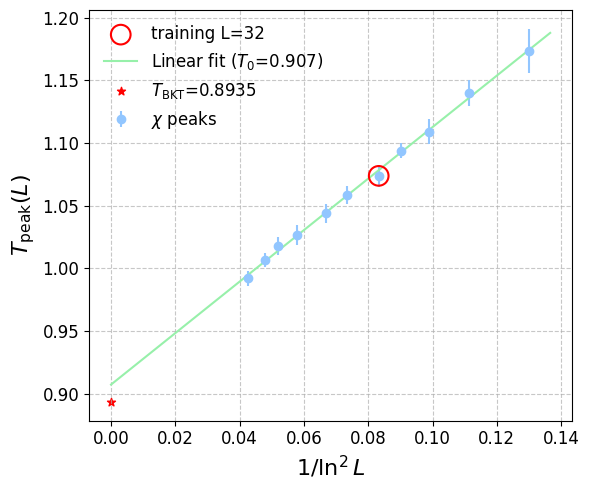

In [75]:
x = 1.0 / np.log(fs_L) ** 2
p_lin_chi  = np.polyfit(x, T_peak_chi, 1)
T_lin_chi  = p_lin_chi[1]

training_size_L = 32
training_size_index = np.where(fs_L == training_size_L)[0][0]
x_highlight = x[training_size_index]
y_highlight = T_peak_chi[training_size_index]
x_highlight_bkt = 0.0
y_highlight_bkt = 0.8935

# Linearised 1/ln^2(L) vs T peaks
fig, ax = plt.subplots(figsize=(6, 5))
ax.errorbar(x, T_peak_chi, yerr=T_peak_chi_err,  fmt='o', label=r'$\chi$ peaks')
ax.scatter(x_highlight, y_highlight, s=200, facecolors='none', edgecolors='red', linewidths=1.5, zorder=5, label=f'training L={training_size_L}')
x_fit = np.linspace(0, x.max()*1.05, 200)
ax.plot(x_fit, np.polyval(p_lin_chi,  x_fit),  label=f'Linear fit ($T_0$={T_lin_chi:.3f})')
ax.scatter(x_highlight_bkt, y_highlight_bkt, color='red', marker='*', label=r'$T_{\mathrm{BKT}}$=0.8935')
ax.set_xlabel(r'$1/\ln^2 L$', fontsize=16)
ax.set_ylabel(r'$T_{\mathrm{peak}}(L)$', fontsize=16)
# ax.set_title(r'FM finite‑size scaling of $\chi$ peak temperatures', fontsize=16)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, prop={'size': 12}, markerscale=1.0, frameon=False, loc='upper left')
ax.tick_params(axis='both', which='major', labelsize=12)

ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()